# Описание проекта. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

**Описание процесса обработки** 

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных** 
Данные хранятся в базе данных PostgreSQL. 
Она состоит из нескольких таблиц:

•	steel.data_arc — данные об электродах;

•	steel.data_bulk — данные об объёме сыпучих материалов;

•	steel.data_bulk_time — данные о времени подачи сыпучих материалов;

•	steel.data_gas — данные о продувке сплава газом;

•	steel.data_temp — данные об измерениях температуры;

•	steel.data_wire — данные об объёме проволочных материалов;

•	steel.data_wire_time — данные о времени подачи проволочных материалов.

**Таблица steel.data_arc**

•	key — номер партии;

•	BeginHeat — время начала нагрева;

•	EndHeat — время окончания нагрева;

•	ActivePower — значение активной мощности;

•	ReactivePower — значение реактивной мощности.

**Таблица steel.data_bulk**

•	key — номер партии;

•	Bulk1 … Bulk15 — объём подаваемого материала.

**Таблица steel.data_bulk_time**

•	key — номер партии;

•	Bulk1 … Bulk15 — время подачи материала.

**Таблица steel.data_gas**

•	key — номер партии;

•	gas — объём подаваемого газа.

**Таблица steel.data_temp**

•	key — номер партии;

•	MesaureTime — время замера;

•	Temperature — значение температуры.

**Таблица steel.data_wire**

•	key — номер партии;

•	Wire1 … Wire15 — объём подаваемых проволочных материалов.

**Таблица steel.data_wire_time**

•	key — номер партии;

•	Wire1 … Wire15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


## Подключение к базе. Загрузка таблиц sql

### Импортируем необходимые нам библиотеки и функции

In [1]:
! pip install -q skorch

     |████████████████████████████████| 239 kB 2.5 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from math import ceil
import random

import torch
import torch.nn as nn

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit 

from skorch import NeuralNetRegressor


from sqlalchemy import create_engine, text

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import make_scorer

from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.dummy import DummyRegressor


In [3]:
RANDOM_STATE = 40324

### Конфигурация для подключения к базе данных data-science-final

In [4]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-final' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)

### Выведем названи таблиц, которые есть в базе данных.

In [6]:
query = '''
SELECT *
FROM information_schema.tables
WHERE table_schema='steel'
      AND table_type='BASE TABLE';
'''
tables = pd.read_sql_query(query, con=engine) 
#tables = pd.DataFrame(engine.connect().execute(text(query)))
tables

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,data-science-final,steel,data_arc,BASE TABLE,None,None,None,None,None,YES,NO,None
1,data-science-final,steel,data_bulk,BASE TABLE,None,None,None,None,None,YES,NO,None
2,data-science-final,steel,data_bulk_time,BASE TABLE,None,None,None,None,None,YES,NO,None
3,data-science-final,steel,data_gas,BASE TABLE,None,None,None,None,None,YES,NO,None
4,data-science-final,steel,data_temp,BASE TABLE,None,None,None,None,None,YES,NO,None
5,data-science-final,steel,data_wire,BASE TABLE,None,None,None,None,None,YES,NO,None
6,data-science-final,steel,data_wire_time,BASE TABLE,None,None,None,None,None,YES,NO,None


**Итог** Произведено подключение к базе данных. Выведены названия таблиц из проекта 'steel'. Названия таблиц и их количество соответсвует описанию в задании.

### Загрузим данные из таблицы data_arc - данные об электродах.

In [7]:
query = '''
SELECT COUNT(*)
FROM steel.data_arc;
'''
count = pd.read_sql_query(query, con=engine) 
count

,count
0,14876


In [8]:
query = '''
SELECT * 
FROM information_schema.columns
WHERE table_name IN ('data_arc');
'''
colum = pd.read_sql_query(query, con=engine) 
#colum = pd.DataFrame(engine.connect().execute(text(query)))
colum

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,data-science-final,steel,data_arc,key,1,None,YES,integer,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,data-science-final,steel,data_arc,BeginHeat,2,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,data-science-final,steel,data_arc,EndHeat,3,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,data-science-final,steel,data_arc,ActivePower,4,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,data-science-final,steel,data_arc,ReactivePower,5,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [9]:
query = '''
SELECT *
FROM steel.data_arc;
'''

pd.read_sql_query(query, con=engine) 
#pd.DataFrame(engine.connect().execute(text(query))).head()


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,03:58:58,04:01:35,0.533670,0.354439
14872,3241,04:05:04,04:08:04,0.676604,0.523631
14873,3241,04:16:41,04:19:45,0.733899,0.475654
14874,3241,04:31:51,04:32:48,0.220694,0.145768


Переименуем названия столбцов, которые начинаются с заглавных букв, и переведем время в секунды, т.к. у нас указано только время в формате 24 часов без указания даты.

In [10]:
query = '''
SELECT key,
       CAST(EXTRACT(HOUR FROM "BeginHeat") * 3600 + EXTRACT(MINUTE FROM "BeginHeat") * 60 +
       EXTRACT(SECOND FROM "BeginHeat") AS int) AS begin_heat,
       CAST(EXTRACT(HOUR FROM "EndHeat") * 3600 + EXTRACT(MINUTE FROM "EndHeat") * 60 +
       EXTRACT(SECOND FROM "EndHeat") AS int) AS end_heat,
       CAST("ActivePower" AS FLOAT) AS active_power,
       CAST("ReactivePower" AS FLOAT) AS reactive_power
FROM steel.data_arc;
'''
data_arc = pd.read_sql_query(query, con=engine) 
#data_arc = pd.DataFrame(engine.connect().execute(text(query)))
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power
0,1,39734,39962,0.976059,0.687084
1,1,40048,40233,0.805607,0.520285
2,1,40304,40476,0.744363,0.498805
3,1,40694,41059,1.659363,1.062669
4,1,41169,41317,0.692755,0.414397


**data_arc - данные об электрода** - количество строк 14876, данные есть, количество столбцов и их содержание соответсвует описанию.

### Загрузим данные из таблицы data_bulk - данные об объёме сыпучих материалов

In [11]:
query = '''
SELECT COUNT(*)
FROM steel.data_bulk;
'''
count_db = pd.read_sql_query(query, con=engine) 
count_db


,count
0,3129


In [12]:
query = '''
SELECT * 
FROM information_schema.columns
WHERE table_name IN ('data_bulk');
'''

colum_db = pd.read_sql_query(query, con=engine) 
#colum_db = pd.DataFrame(engine.connect().execute(text(query)))
colum_db

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,data-science-final,steel,data_bulk,key,1,None,YES,integer,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,data-science-final,steel,data_bulk,Bulk 1,2,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,data-science-final,steel,data_bulk,Bulk 2,3,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,data-science-final,steel,data_bulk,Bulk 3,4,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,data-science-final,steel,data_bulk,Bulk 4,5,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,data-science-final,steel,data_bulk,Bulk 5,6,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,data-science-final,steel,data_bulk,Bulk 6,7,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
7,data-science-final,steel,data_bulk,Bulk 7,8,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
8,data-science-final,steel,data_bulk,Bulk 8,9,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
9,data-science-final,steel,data_bulk,Bulk 9,10,None,YES,numeric,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [13]:
query = '''
SELECT *       
FROM steel.data_bulk;
'''
pd.read_sql_query(query, con=engine)
#pd.DataFrame(engine.connect().execute(text(query))).head()


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Сразу поменяем названия столбцов

In [14]:
query = '''
SELECT key,
       "Bulk 1" AS bulk_1,
       "Bulk 2" AS bulk_2,
       "Bulk 3" AS bulk_3,
       "Bulk 4" AS bulk_4,
       "Bulk 5" AS bulk_5,
       "Bulk 6" AS bulk_6,
       "Bulk 7" AS bulk_7,
       "Bulk 8" AS bulk_8,
       "Bulk 9" AS bulk_9,
       "Bulk 10" AS bulk_10,
       "Bulk 11" AS bulk_11,
       "Bulk 12" AS bulk_12,
       "Bulk 13" AS bulk_13,
       "Bulk 14" AS bulk_14,
       "Bulk 15" AS bulk_15
       
FROM steel.data_bulk;
'''
data_bulk = pd.read_sql_query(query, con=engine)
#data_bulk = pd.DataFrame(engine.connect().execute(text(query)))
data_bulk.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


**steel.data_bulk — данные об объёме сыпучих материалов** - количество строк 3129, данные есть, количество столбцов и их содержание соответсвует описанию.

### Загрузим данные из таблицы data_bulk_time — данные о времени подачи сыпучих материалов

In [15]:
query = '''
SELECT COUNT(*)
FROM steel.data_bulk_time;
'''
count_dbt = pd.read_sql_query(query, con=engine) 
count_dbt


,count
0,3129


In [16]:
query = '''
SELECT * 
FROM information_schema.columns
WHERE table_name IN ('data_bulk_time');
'''
colum_dbt = pd.read_sql_query(query, con=engine) 
#colum_dbt = pd.DataFrame(engine.connect().execute(text(query)))
colum_dbt

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,data-science-final,steel,data_bulk_time,key,1,None,YES,integer,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,data-science-final,steel,data_bulk_time,Bulk 1,2,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,data-science-final,steel,data_bulk_time,Bulk 2,3,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,data-science-final,steel,data_bulk_time,Bulk 3,4,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,data-science-final,steel,data_bulk_time,Bulk 4,5,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,data-science-final,steel,data_bulk_time,Bulk 5,6,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,data-science-final,steel,data_bulk_time,Bulk 6,7,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
7,data-science-final,steel,data_bulk_time,Bulk 7,8,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
8,data-science-final,steel,data_bulk_time,Bulk 8,9,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
9,data-science-final,steel,data_bulk_time,Bulk 9,10,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [17]:
query = '''
SELECT *       
FROM steel.data_bulk_time;
'''
#pd.DataFrame(engine.connect().execute(text(query))).head()
pd.read_sql_query(query, con=engine) 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,None,None,22:51:28,None,None,None,None,None,None,None,None,22:46:52,None,22:46:52,22:46:52
3125,3238,None,None,23:39:11,None,None,None,None,None,None,None,None,23:33:09,None,23:33:09,23:33:09
3126,3239,None,None,None,None,None,01:51:58,None,None,None,None,None,01:39:41,None,01:33:25,01:33:25
3127,3240,None,None,None,None,None,03:12:40,None,None,None,None,None,None,None,02:41:27,02:41:27


Переименуем названия столбцов, которые начинаются с заглавных букв, и переведем время в секунды, т.к. у нас указано только время в формате 24 часов без указания даты.

In [18]:
query = '''
SELECT key,
       CAST(EXTRACT(HOUR FROM "Bulk 1") * 3600 + EXTRACT(MINUTE FROM "Bulk 1") * 60 +
       EXTRACT(SECOND FROM "Bulk 1") AS int) AS bulk_1,
       CAST(EXTRACT(HOUR FROM "Bulk 2") * 3600 + EXTRACT(MINUTE FROM "Bulk 2") * 60 +
       EXTRACT(SECOND FROM "Bulk 2") AS int) AS bulk_2,
       CAST(EXTRACT(HOUR FROM "Bulk 3") * 3600 + EXTRACT(MINUTE FROM "Bulk 3") * 60 +
       EXTRACT(SECOND FROM "Bulk 3") AS int) AS bulk_3,
       CAST(EXTRACT(HOUR FROM "Bulk 4") * 3600 + EXTRACT(MINUTE FROM "Bulk 4") * 60 +
       EXTRACT(SECOND FROM "Bulk 4") AS int) AS bulk_4,
       CAST(EXTRACT(HOUR FROM "Bulk 5") * 3600 + EXTRACT(MINUTE FROM "Bulk 5") * 60 +
       EXTRACT(SECOND FROM "Bulk 5") AS int) AS bulk_5,
       CAST(EXTRACT(HOUR FROM "Bulk 6") * 3600 + EXTRACT(MINUTE FROM "Bulk 6") * 60 +
       EXTRACT(SECOND FROM "Bulk 6") AS int) AS bulk_6,
       CAST(EXTRACT(HOUR FROM "Bulk 7") * 3600 + EXTRACT(MINUTE FROM "Bulk 7") * 60 +
       EXTRACT(SECOND FROM "Bulk 7") AS int) AS bulk_7,
       CAST(EXTRACT(HOUR FROM "Bulk 8") * 3600 + EXTRACT(MINUTE FROM "Bulk 8") * 60 +
       EXTRACT(SECOND FROM "Bulk 8") AS int) AS bulk_8,
       CAST(EXTRACT(HOUR FROM "Bulk 9") * 3600 + EXTRACT(MINUTE FROM "Bulk 9") * 60 +
       EXTRACT(SECOND FROM "Bulk 9") AS int) AS bulk_9,
       CAST(EXTRACT(HOUR FROM "Bulk 10") * 3600 + EXTRACT(MINUTE FROM "Bulk 10") * 60 +
       EXTRACT(SECOND FROM "Bulk 10") AS int) AS bulk_10,
       CAST(EXTRACT(HOUR FROM "Bulk 11") * 3600 + EXTRACT(MINUTE FROM "Bulk 11") * 60 +
       EXTRACT(SECOND FROM "Bulk 11") AS int) AS bulk_11,
       CAST(EXTRACT(HOUR FROM "Bulk 12") * 3600 + EXTRACT(MINUTE FROM "Bulk 12") * 60 +
       EXTRACT(SECOND FROM "Bulk 12") AS int) AS bulk_12,
       CAST(EXTRACT(HOUR FROM "Bulk 13") * 3600 + EXTRACT(MINUTE FROM "Bulk 13") * 60 +
       EXTRACT(SECOND FROM "Bulk 13") AS int) AS bulk_13,
       CAST(EXTRACT(HOUR FROM "Bulk 14") * 3600 + EXTRACT(MINUTE FROM "Bulk 14") * 60 +
       EXTRACT(SECOND FROM "Bulk 14") AS int) AS bulk_14,       
       CAST(EXTRACT(HOUR FROM "Bulk 15") * 3600 + EXTRACT(MINUTE FROM "Bulk 15") * 60 +
       EXTRACT(SECOND FROM "Bulk 15") AS int) AS bulk_15

       
FROM steel.data_bulk_time;
'''
#data_bulk_time = pd.DataFrame(engine.connect().execute(text(query)))
data_bulk_time = pd.read_sql_query(query, con=engine) 
data_bulk_time.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,40890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39832.0,NaN,39832.0,39832.0
1,2,NaN,NaN,NaN,42398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42020.0,NaN,42020.0,42020.0
2,3,NaN,NaN,NaN,45066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43780.0,NaN,43780.0,43780.0
3,4,NaN,NaN,NaN,46123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45684.0,NaN,45684.0,45684.0
4,5,NaN,NaN,NaN,47930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47576.0,NaN,47576.0,47576.0


**data_bulk_time — данные о времени подачи сыпучих материалов** - количество строк 3129, данные есть, количество столбцов и их содержание соответсвует описанию.

### Загрузим данные из таблицы data_gas — данные о продувке сплава газом

In [19]:
query = '''
SELECT COUNT(*)
FROM steel.data_gas;
'''
count_dg = pd.read_sql_query(query, con=engine) 
count_dg


,count
0,3239


In [20]:
query = '''
SELECT *
FROM steel.data_gas;
'''
#data_gas = pd.DataFrame(engine.connect().execute(text(query)))
data_gas = pd.read_sql_query(query, con=engine)
data_gas.head(5)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


**data_gas — данные о продувке сплава газом** - количество строк 3239, данные есть, количество столбцов и их содержание соответсвует описанию.

### Загрузим данные из таблицы data_temp  — данные об измерениях температуры

In [21]:
query = '''
SELECT COUNT(*)
FROM steel.data_temp;
'''
count_dt = pd.read_sql_query(query, con=engine) 
count_dt


,count
0,15907


In [22]:
query = '''
SELECT *
FROM steel.data_temp;
'''
data_temp = pd.read_sql_query(query, con=engine) 
#data_temp = pd.DataFrame(engine.connect().execute(text(query)))
data_temp.head()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


Переименуем названия столбцов, которые начинаются с заглавных букв, и переведем время в секунды, т.к. у нас указано только время в формате 24 часов без указания даты.

In [23]:
query = '''
SELECT key,
       CAST(EXTRACT(HOUR FROM "MesaureTime") * 3600 + EXTRACT(MINUTE FROM "MesaureTime") * 60 +
       EXTRACT(SECOND FROM "MesaureTime") AS int) AS mesaure_time,
       "Temperature" AS temperature

       
FROM steel.data_temp;
'''
data_temp = pd.read_sql_query(query, con=engine) 
#data_temp = pd.DataFrame(engine.connect().execute(text(query)))
data_temp.head(5)

,key,mesaure_time,temperature
0,1,40578,1571.0
1,1,41153,1604.0
2,1,41351,1618.0
3,1,41401,1601.0
4,1,41439,1613.0


**data_temp  — данные об измерениях температуры** - количество строк 15907, данные есть, количество столбцов и их содержание соответсвует описанию.

### Загрузим данные из таблицы data_wire — данные об объёме проволочных материалов

In [24]:
query = '''
SELECT COUNT(*)
FROM steel.data_wire;
'''
count_dw = pd.read_sql_query(query, con=engine) 
count_dw


,count
0,3081


In [25]:
query = '''
SELECT *
FROM steel.data_wire;
'''
data_wire = pd.read_sql_query(query, con=engine) 
#data_wire = pd.DataFrame(engine.connect().execute(text(query)))
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**data_wire — данные об объёме проволочных материалов** - количество строк 3081, данные есть, количество столбцов 10, что отличается от описания, содержание столбцов соответсвует описанию.

### Загрузим данные из таблицы data_wire_time — данные о времени подачи проволочных материалов

In [26]:
query = '''
SELECT COUNT(*)
FROM steel.data_wire_time;
'''
count_dwt = pd.read_sql_query(query, con=engine) 
count_dwt

,count
0,3081


In [27]:
query = '''
SELECT * 
FROM information_schema.columns
WHERE table_name IN ('data_wire_time');
'''
colum_dwt = pd.read_sql_query(query, con=engine) 
#colum_dwt = pd.DataFrame(engine.connect().execute(text(query)))
colum_dwt

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,data-science-final,steel,data_wire_time,key,1,None,YES,integer,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,data-science-final,steel,data_wire_time,Wire 1,2,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,data-science-final,steel,data_wire_time,Wire 2,3,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,data-science-final,steel,data_wire_time,Wire 3,4,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,data-science-final,steel,data_wire_time,Wire 4,5,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,data-science-final,steel,data_wire_time,Wire 5,6,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,data-science-final,steel,data_wire_time,Wire 6,7,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
7,data-science-final,steel,data_wire_time,Wire 7,8,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
8,data-science-final,steel,data_wire_time,Wire 8,9,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES
9,data-science-final,steel,data_wire_time,Wire 9,10,None,YES,time without time zone,None,None,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [28]:
query = '''
SELECT *
FROM steel.data_wire_time;
'''
#pd.DataFrame(engine.connect().execute(text(query))).head()
pd.read_sql_query(query, con=engine) 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
3076,3237,22:50:20,None,None,None,None,None,None,None,None
3077,3238,23:38:24,None,None,None,None,None,None,None,None
3078,3239,01:50:43,None,None,None,None,None,None,None,None
3079,3240,03:12:02,None,None,None,None,None,None,None,None


Переименуем названия столбцов, которые начинаются с заглавных букв, и переведем время в секунды, т.к. у нас указано только время в формате 24 часов без указания даты.

In [29]:
query = '''
SELECT key,
       CAST(EXTRACT(HOUR FROM "Wire 1") * 3600 + EXTRACT(MINUTE FROM "Wire 1") * 60 +
       EXTRACT(SECOND FROM "Wire 1") AS int) AS wire_1,
       CAST(EXTRACT(HOUR FROM "Wire 2") * 3600 + EXTRACT(MINUTE FROM "Wire 2") * 60 +
       EXTRACT(SECOND FROM "Wire 2") AS int) AS wire_2,
       CAST(EXTRACT(HOUR FROM "Wire 3") * 3600 + EXTRACT(MINUTE FROM "Wire 3") * 60 +
       EXTRACT(SECOND FROM "Wire 3") AS int) AS wire_3,
       CAST(EXTRACT(HOUR FROM "Wire 4") * 3600 + EXTRACT(MINUTE FROM "Wire 4") * 60 +
       EXTRACT(SECOND FROM "Wire 4") AS int) AS wire_4,
       CAST(EXTRACT(HOUR FROM "Wire 5") * 3600 + EXTRACT(MINUTE FROM "Wire 5") * 60 +
       EXTRACT(SECOND FROM "Wire 5") AS int) AS wire_5,
       CAST(EXTRACT(HOUR FROM "Wire 6") * 3600 + EXTRACT(MINUTE FROM "Wire 6") * 60 +
       EXTRACT(SECOND FROM "Wire 6") AS int) AS wire_6,
       CAST(EXTRACT(HOUR FROM "Wire 7") * 3600 + EXTRACT(MINUTE FROM "Wire 7") * 60 +
       EXTRACT(SECOND FROM "Wire 7") AS int) AS wire_7,
       CAST(EXTRACT(HOUR FROM "Wire 8") * 3600 + EXTRACT(MINUTE FROM "Wire 8") * 60 +
       EXTRACT(SECOND FROM "Wire 8") AS int) AS wire_8,
       CAST(EXTRACT(HOUR FROM "Wire 9") * 3600 + EXTRACT(MINUTE FROM "Wire 9") * 60 +
       EXTRACT(SECOND FROM "Wire 9") AS int) AS wire_9
       
FROM steel.data_wire_time;
'''
data_wire_time = pd.read_sql_query(query, con=engine) 
#data_wire_time = pd.DataFrame(engine.connect().execute(text(query)))
data_wire_time.head(5)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,40301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,42370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,44027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,46085.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,47895.0,48726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**data_wire_time — данные о времени подачи проволочных материалов** - количество строк 3081, данные есть, количество столбцов 10, что отличается от описания, содержание столбцов соответсвует описанию.

**Вывод**:
На данном этапе загрузили следующие таблицы:

• data_arc — данные об электродах;

• data_bulk — данные об объёме сыпучих материалов;

• data_bulk_time — данные о времени подачи сыпучих материалов;

• data_gas — данные о продувке сплава газом;

• data_temp — данные об измерениях температуры;

• data_wire — данные об объёме проволочных материалов;

• data_wire_time — данные о времени подачи проволочных материалов.

Таблицы и их содержимое в целом соответсвуют описанию, за исключением таблиц data_wire и data_wire_time, где количество столбцов отличается от описания. Фактически присутсвуют столбцы - key, Wire 1, Wire 2,	Wire 3,	Wire 4,	Wire 5,	Wire 6,	Wire 7,	Wire 8,	Wire 9. Также в ряде таблиц изменили название колонок, которые начинались с большой буквы, и столбы с форматом времени time перевели в секунды.

## Исследовательский анализ и предобработка данных

### Таблица data_arc - данные об электродах: 

o	Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.

o	Вам нужно либо удалить всю партию с аномальным значением, либо заменить аномальное значение, основываясь на нормальных наблюдениях.

o	Попробуйте сгенерировать новые признаки, которые могут пригодиться при обучении: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами и другие.

o	При агрегировании наблюдений по ключу учитывайте порядок арифметических действий: сначала сгенерируйте новые признаки, затем уже агрегируйте наблюдения.


#### Сначала напишем функцию для получения информации о датасете (вывод первых пяти срок, общей информации методом info(), описания информации в столбцах методом discribe(), наличия явных дубликатов, количества пропусков)

In [30]:
def get_info(data):
    display(f'Вывод первых 5-ти строк датасета', data.head())
    display(data.info())
    print('Количество явных дубликатов:' , data.duplicated().sum())
    print('Количество пропусков:\n', data.isna().sum())
    display(data.describe())
    

А также функцию get_info_2, в которой дополнительно есть получение графика распределения значений признаков.

In [31]:
def get_info_2(data):
    display(f'Вывод первых 5-ти строк датасета', data.head())
    display(data.info())
    print('Количество явных дубликатов:' , data.duplicated().sum())
    print('Количество пропусков:\n', data.isna().sum())
    display(data.describe())
    data.hist(figsize=(9, 9));

In [32]:
get_info(data_arc)

'Вывод первых 5-ти строк датасета'

,key,begin_heat,end_heat,active_power,reactive_power
0,1,39734,39962,0.976059,0.687084
1,1,40048,40233,0.805607,0.520285
2,1,40304,40476,0.744363,0.498805
3,1,40694,41059,1.659363,1.062669
4,1,41169,41317,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   begin_heat      14876 non-null  int64  
 2   end_heat        14876 non-null  int64  
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 581.2 KB


None

Количество явных дубликатов: 0
Количество пропусков:
 key               0
begin_heat        0
end_heat          0
active_power      0
reactive_power    0
dtype: int64


,key,begin_heat,end_heat,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,43148.600027,43192.494689,0.670441,0.452592
std,934.571502,24998.711157,24996.782760,0.408159,5.878702
min,1.000000,1.000000,7.000000,0.030002,-715.504924
25%,806.000000,21776.750000,21793.750000,0.395297,0.290991
50%,1617.000000,42775.000000,42832.000000,0.555517,0.415962
75%,2429.000000,64685.750000,64730.250000,0.857034,0.637371
max,3241.000000,86375.000000,86398.000000,3.731596,2.676388


Из полученны данных выидим, что у нас размер датасета 14876 на 5, пропусков в данных - нет, полных дубликатов в данных - нет. Рассмотрим более детально каждый столбец. 

#### Столбец key - номер партии

Из полученных данных видим, что минимальное значение номера партии 1, максимальное = 3241. 
Посмотрим сколько уникальных значений номеров партии в столбце.  

In [33]:
print('Kоличество уникальных значений:', len(data_arc['key'].unique()))

Kоличество уникальных значений: 3214


Посмотрим распределение партий по количеству раз обработки

In [34]:
data_arc.groupby('key')['key'].count().value_counts(normalize=True)

4     0.277536
5     0.236154
3     0.161792
6     0.152458
7     0.063783
2     0.054138
8     0.026136
1     0.012134
9     0.008712
10    0.002800
11    0.001556
12    0.000933
13    0.000622
15    0.000622
14    0.000311
16    0.000311
Name: key, dtype: float64

Из полученных данных видим, что партии подвергались обратке от 1 о 16 раз. Наибольшее количество партий (около 28% партий) подвергалось обработке 4 раза. Партий, которые подвергались обработке 10 и более раз, очень мало (менее 1 %). 

#### Столбцы begin_heat и еnd_heat - время начала и окончания нагрева. 

Время изначально было дано в формате time (hh:mm:ss) в 24 часовом формате без привязке к дате события, поэтому еще на этапе загрузки перевели его в секунды. Распределение времени выглядит логичным, анамальных данных нет. Само по себе время для нас не очень информативно, добавим новый признак время нагрева, но предварительно проверим, всегда ли время начала нагрева меньше времени окончания нагрева (такой вариант может говорить, что начали нагревать в конце дня и закончили нагрев в начале следующего дня). Также проверим вариант, когда время начала нагрева равно времени окончания нагрева (это скорее всего ошибочные данные). 

In [35]:
data_arc.query('begin_heat > end_heat')

,key,begin_heat,end_heat,active_power,reactive_power
580,126,86375,115,0.527388,0.405463
1170,257,86337,7,0.268811,0.175647
1280,280,86217,103,1.197192,0.728587
1953,421,86313,117,0.774585,0.583186
2952,642,85975,193,2.415316,1.946081
3438,745,86307,14,0.403792,0.281718
4250,913,86302,94,0.787956,0.537366
4752,1026,86344,427,1.680239,1.400063
5400,1175,86365,307,1.325558,0.893414
6456,1404,86193,65,1.217748,0.833978


In [36]:
data_arc.query('begin_heat == end_heat')

,key,begin_heat,end_heat,active_power,reactive_power


Данных, где врем я начала и окончания нагрева совпадает не выявлено, но есть данные, когда время окончания нагрева меньше времени начала нагрева, это надо учесть при расчете нового признака времени нагрева. В этом случае время нагроева будем считать по формуле- (24*3600 - начало нагрева +конец нагрева)

##### Расчитаем время нагрева, предварительно написав функцию одной строки для его расчета. Функция на входе принимает строку датасета и  в зависимости от условия расчитывает время нагрева, которое сохраняетсяв новом столбце time_heat.  На выходе получаем новую строку с добавленным столбцом. Затем применим данную функцию ко всему датасету.

In [37]:
def get_time_heat(row):
    if row['begin_heat'] < row['end_heat']:
        row['time_heat'] = row['end_heat'] - row['begin_heat']
    else:
        row['time_heat'] = 24*3600 - row['begin_heat'] + row['end_heat']
    return row    

In [38]:
data_arc = data_arc.apply(get_time_heat, axis=1)

In [39]:
display(data_arc.head())
data_arc.info()

,key,begin_heat,end_heat,active_power,reactive_power,time_heat
0,1.0,39734.0,39962.0,0.976059,0.687084,228.0
1,1.0,40048.0,40233.0,0.805607,0.520285,185.0
2,1.0,40304.0,40476.0,0.744363,0.498805,172.0
3,1.0,40694.0,41059.0,1.659363,1.062669,365.0
4,1.0,41169.0,41317.0,0.692755,0.414397,148.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  float64
 1   begin_heat      14876 non-null  float64
 2   end_heat        14876 non-null  float64
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
 5   time_heat       14876 non-null  float64
dtypes: float64(6)
memory usage: 697.4 KB


##### Посмотрим распределение нового признака 

In [40]:
data_arc['time_heat'].describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: time_heat, dtype: float64

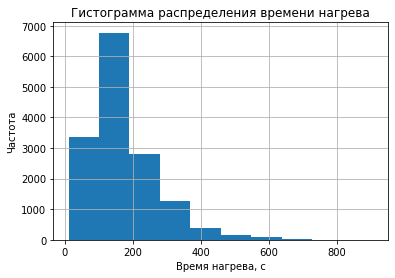

In [41]:
data_arc['time_heat'].hist()
plt.title('Гистограмма распределения времени нагрева')
plt.xlabel('Время нагрева, с')
plt.ylabel('Частота')
plt.show()

Из полученных данных видим, что в среднем процесс длится около 3 минут, минимальное время нагрева 11 с, максимальное чуть более 15 мин, распределение времени нагрева выглядит адекватным.

#### Столбцы active_power,	reactive_power - активная и реактивная мощность

Сразу обращают на себя внимание отрицательные и дастаточно большие значения реактивной мощности. В связи с этим первое, что посмотрим это значения реактивной мощности меньше или равное 0.

In [42]:
data_arc.query('reactive_power <= 0')

,key,begin_heat,end_heat,active_power,reactive_power,time_heat
9781,2116.0,2688.0,2797.0,0.495782,-715.504924,109.0


Обнаружено только одно такое значение, оно явно аномальное, попробуем его заменить. Посмотрим есть ли взаимосвязь между активной и реактивной мощьностью.

In [43]:
data_arc.query('index != 9781')[['active_power', 'reactive_power']].corr()

,active_power,reactive_power
active_power,1.000000,0.963182
reactive_power,0.963182,1.000000


Прослеживается сильная положительная корреляция между этими признаками. Найдем среднее отношение реактивной мощности к активной.

In [44]:
k = (data_arc.query('index != 9781')['reactive_power'] / data_arc.query('index != 9781')['active_power']).mean()
k

0.7494744418177819

Получили, что в среднем реактивная можность составляет около 0.75 активной мощности. Изменим значение реактивной мощности в соответсвии с этим.

In [45]:
data_arc.loc[data_arc['reactive_power'] < 0, 'reactive_power'] = data_arc['active_power']*k

In [46]:
data_arc.loc[9781]

key               2116.000000
begin_heat        2688.000000
end_heat          2797.000000
active_power         0.495782
reactive_power       0.371576
time_heat          109.000000
Name: 9781, dtype: float64

In [47]:
data_arc['reactive_power'].describe()

count    14876.000000
mean         0.500715
std          0.310872
min          0.020806
25%          0.291008
50%          0.415962
75%          0.637371
max          2.676388
Name: reactive_power, dtype: float64

#### Рассчитаем общую мощность (кажущуюся мощность) по формуле:
$${\displaystyle |S|={\sqrt {P ^{2} + Q ^{2}}}},$$

где

$P$ - активная мощность,

$Q$ - реактивная мощность.

In [48]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power,time_heat,full_power
0,1.0,39734.0,39962.0,0.976059,0.687084,228.0,1.193639
1,1.0,40048.0,40233.0,0.805607,0.520285,185.0,0.959010
2,1.0,40304.0,40476.0,0.744363,0.498805,172.0,0.896038
3,1.0,40694.0,41059.0,1.659363,1.062669,365.0,1.970470
4,1.0,41169.0,41317.0,0.692755,0.414397,148.0,0.807239


##### Пострим графики распределения полной мощности, активной и реактивной.

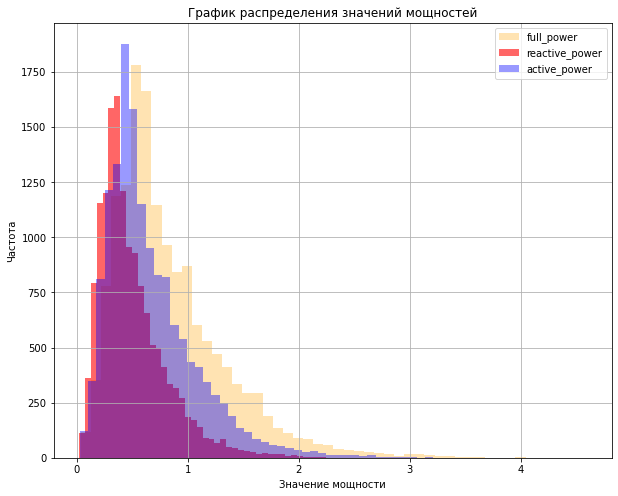

In [49]:
plt.figure(figsize=(10, 8))
data_arc['full_power'].plot(kind='hist', bins=50, legend=True, color='orange', grid=True, alpha=0.3)
data_arc['reactive_power'].plot(kind='hist', bins=50, legend=True, color='red', grid=True, alpha=0.6)
data_arc['active_power'].plot(kind='hist', bins=50, legend=True, color='blue', grid=True, alpha=0.4)
plt.title('График распределения значений мощностей')
plt.ylabel('Частота')
plt.xlabel('Значение мощности')
plt.show()

Распределения знаений мощностей выглядит адекватно, со смещением купола влево и длинным хвостом справа. 

##### Рассчитаем коэффициент мощности по формуле.

Коэффициент мощности равен отношению активной мощности к кажущейся мощности.

In [50]:
data_arc['koef_power'] = data_arc['active_power']/data_arc['full_power']
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power,time_heat,full_power,koef_power
0,1.0,39734.0,39962.0,0.976059,0.687084,228.0,1.193639,0.817717
1,1.0,40048.0,40233.0,0.805607,0.520285,185.0,0.959010,0.840041
2,1.0,40304.0,40476.0,0.744363,0.498805,172.0,0.896038,0.830728
3,1.0,40694.0,41059.0,1.659363,1.062669,365.0,1.970470,0.842115
4,1.0,41169.0,41317.0,0.692755,0.414397,148.0,0.807239,0.858178


Построим график расспределения коэффициента мощности

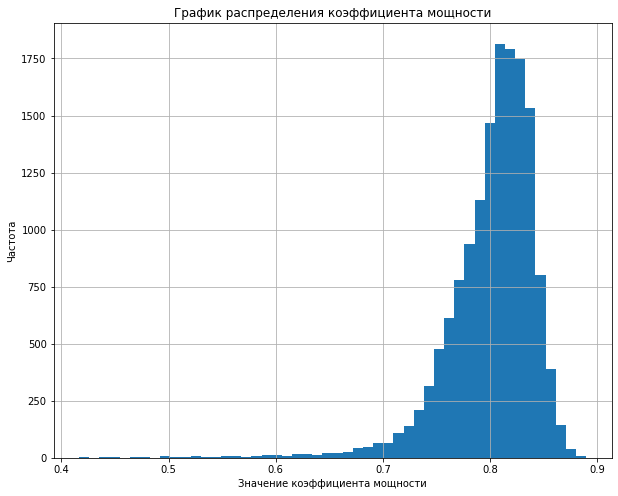

In [51]:
plt.figure(figsize=(10, 8))
data_arc['koef_power'].plot(kind='hist', bins=50,  grid=True)
plt.title('График распределения коэффициента мощности')
plt.ylabel('Частота')
plt.xlabel('Значение коэффициента мощности')
plt.show()

Распределение выглядит логичным, купол смещен вправо, наблюдается длинный хвост слева.

##### Добавим еще один дополнительный признак energy, кторый посчитаем как полная мощность умноженная на время обработки 

In [52]:
data_arc['energy'] = data_arc['full_power']*data_arc['time_heat']
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power,time_heat,full_power,koef_power,energy
0,1.0,39734.0,39962.0,0.976059,0.687084,228.0,1.193639,0.817717,272.149755
1,1.0,40048.0,40233.0,0.805607,0.520285,185.0,0.959010,0.840041,177.416785
2,1.0,40304.0,40476.0,0.744363,0.498805,172.0,0.896038,0.830728,154.118502
3,1.0,40694.0,41059.0,1.659363,1.062669,365.0,1.970470,0.842115,719.221394
4,1.0,41169.0,41317.0,0.692755,0.414397,148.0,0.807239,0.858178,119.471318


In [53]:
data_arc['energy'].describe()

count    14876.000000
mean       193.104695
std        258.370165
min          0.403301
25%         53.511149
50%        101.444448
75%        227.380629
max       4165.081851
Name: energy, dtype: float64

#### Перед аггрегацией данных еще раз посмотрим датасет, получив общую информацию по нему, при необходимости исправим типы данных.

In [54]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  float64
 1   begin_heat      14876 non-null  float64
 2   end_heat        14876 non-null  float64
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
 5   time_heat       14876 non-null  float64
 6   full_power      14876 non-null  float64
 7   koef_power      14876 non-null  float64
 8   energy          14876 non-null  float64
dtypes: float64(9)
memory usage: 1.0 MB


In [55]:
col = ['key', 'begin_heat', 'end_heat', 'time_heat']
for i in col:
    data_arc[i] = data_arc[i].astype('int')   



In [56]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   begin_heat      14876 non-null  int64  
 2   end_heat        14876 non-null  int64  
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
 5   time_heat       14876 non-null  int64  
 6   full_power      14876 non-null  float64
 7   koef_power      14876 non-null  float64
 8   energy          14876 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 1.0 MB


#### Агрегируем полученные данные по ключу (key). На данном этапе оставим время начала и время окончания обработки партии электродами, взяв в качестве начального времени - начало первого этапа обработки, а в качестве  конечного времени -  окончание последнего этапа обработки, добавим также общее количество этапов обработки (count_heat).

##### Составим словарь по тому, как мы будем объединять данные по столбцам

In [57]:
agg_func_data_arc = {
    'key' : 'count', 
    'begin_heat' : 'first',
    'end_heat' : 'last',
    'active_power' : 'mean',
    'reactive_power' : 'mean',
    'time_heat' : 'sum',
    'full_power' : 'mean',
    'koef_power' : 'mean',
    'energy' : 'sum'
}


In [58]:
data_arc_grouped = data_arc.groupby('key').agg(agg_func_data_arc).rename(columns={'key':'count_heat'})

In [59]:
data_arc_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   count_heat      3214 non-null   int64  
 1   begin_heat      3214 non-null   int64  
 2   end_heat        3214 non-null   int64  
 3   active_power    3214 non-null   float64
 4   reactive_power  3214 non-null   float64
 5   time_heat       3214 non-null   int64  
 6   full_power      3214 non-null   float64
 7   koef_power      3214 non-null   float64
 8   energy          3214 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 251.1 KB


In [60]:
data_arc_grouped.tail(15)

,count_heat,begin_heat,end_heat,active_power,reactive_power,time_heat,full_power,koef_power,energy
key,,,,,,,,,
3227,6,60661,63450,0.618587,0.425126,881,0.750709,0.823849,744.301055
3228,4,63823,64824,0.712771,0.503624,660,0.872964,0.816842,594.689259
3229,3,65341,66274,0.930851,0.685319,671,1.156283,0.806458,874.505812
3230,3,67380,68970,1.013800,0.782107,727,1.283033,0.796660,1068.254487
3231,6,69570,71173,0.683395,0.506604,930,0.851429,0.805373,968.770131
3232,4,71598,72538,0.754802,0.547152,720,0.932616,0.810171,797.188286
3233,3,73503,74679,0.534245,0.408745,409,0.673144,0.796274,291.827169
3234,2,75076,75668,0.602536,0.427071,315,0.738615,0.813309,246.658530
3235,4,77267,79184,0.616006,0.448044,595,0.762281,0.808203,469.472890


### Таблица data_bulk — данные об объёме сыпучих материалов: 

o	Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
o	Обработайте пропуски. Пропуск означает, что материал не добавляли в партию.


#### Получим первоначальную информацию о датасете, используя info()

In [61]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


#### Изменим тип данных в столбцах с типом данных object на float

In [62]:
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [63]:
data_bulk[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']] = data_bulk[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']].astype('float')

#### Получим информацию о датасете с помощью ранее написанной функции get_info()

'Вывод первых 5-ти строк датасета'

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Количество явных дубликатов: 0
Количество пропусков:
 key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


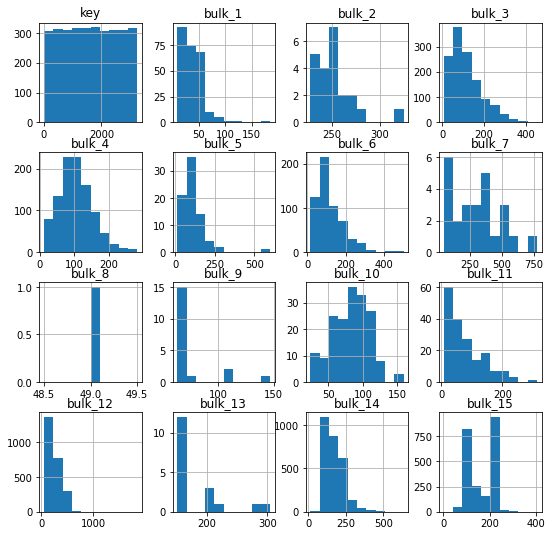

In [64]:
get_info_2(data_bulk)

Из полученных данных видно, что в целом значения объемов сыпучих веществ лежат в положительном диапазоне, нулевых значений нет. Максимальное количество разных сыпучих веществ изменгяется от  49 до 1849, в среднем макимальное количество 150-700. Максимальное количество 1849 bulk_12 значительно отличается от всех остальных максиммальных значений и может являться выбросом. Также мы видим, что вещество bulk_8 добовлялось только один раз. Наиболее часто длобавляемые вщества это bulk_12 bulk_14	bulk_15. Редко добавляемыми являются вещества - bulk_2, bulk_5, bulk_7, bulk_9, bulk_13. Посмотрим более детально bulk_12.

#### Удалим столбец bulk_8 , т.к в нем только одно значение.

In [65]:
data_bulk = data_bulk.drop('bulk_8', axis=1)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_9   19 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2450 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2806 non-null   float64
 14  bulk_15  2248 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


#### Посмотрим в bulk_12 сколько значений превышают значении 700

In [66]:
data_bulk.query('bulk_12 > 700')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,1849.0,NaN,636.0,NaN
308,327,67.0,NaN,NaN,119.0,NaN,NaN,NaN,NaN,NaN,NaN,775.0,NaN,403.0,205.0
1410,1464,31.0,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,NaN,774.0,NaN,306.0,100.0
1629,1689,NaN,NaN,NaN,NaN,NaN,247.0,NaN,NaN,NaN,NaN,733.0,305.0,248.0,224.0
1755,1816,62.0,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,833.0,NaN,249.0,NaN
1933,1999,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,853.0,NaN,366.0,290.0


Партия 303 явно выделяется по значению bulk_12, но пока ее оставим

#### Посмотрим количество уникальных значений в столбце key

In [67]:
print('Количество уникальных значений key:', len(data_bulk['key'].unique()))

Количество уникальных значений key: 3129


Таким образом удостоверились, что все значения key уникальные

#### Так как в услоовиии написано, что отсутсвие значений говорит о том, что сыпучие вещества в партию не добавлялись, то пропуски заполняем нулями.

In [68]:
data_bulk = data_bulk.fillna(0)
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [69]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_9   3129 non-null   float64
 9   bulk_10  3129 non-null   float64
 10  bulk_11  3129 non-null   float64
 11  bulk_12  3129 non-null   float64
 12  bulk_13  3129 non-null   float64
 13  bulk_14  3129 non-null   float64
 14  bulk_15  3129 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


убедились, что все пропуски заполнены

#### Так как значения всех объемов это целые числа, изменим тип данных на int.

In [70]:
data_bulk[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']] = data_bulk[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']].astype('int')

In [71]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   bulk_1   3129 non-null   int64
 2   bulk_2   3129 non-null   int64
 3   bulk_3   3129 non-null   int64
 4   bulk_4   3129 non-null   int64
 5   bulk_5   3129 non-null   int64
 6   bulk_6   3129 non-null   int64
 7   bulk_7   3129 non-null   int64
 8   bulk_9   3129 non-null   int64
 9   bulk_10  3129 non-null   int64
 10  bulk_11  3129 non-null   int64
 11  bulk_12  3129 non-null   int64
 12  bulk_13  3129 non-null   int64
 13  bulk_14  3129 non-null   int64
 14  bulk_15  3129 non-null   int64
dtypes: int64(15)
memory usage: 366.8 KB


#### Удалим строку, где bulk_12 равно 1849

In [72]:
data_bulk = data_bulk.query('bulk_12 != 1849')

In [73]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3128 non-null   int64
 1   bulk_1   3128 non-null   int64
 2   bulk_2   3128 non-null   int64
 3   bulk_3   3128 non-null   int64
 4   bulk_4   3128 non-null   int64
 5   bulk_5   3128 non-null   int64
 6   bulk_6   3128 non-null   int64
 7   bulk_7   3128 non-null   int64
 8   bulk_9   3128 non-null   int64
 9   bulk_10  3128 non-null   int64
 10  bulk_11  3128 non-null   int64
 11  bulk_12  3128 non-null   int64
 12  bulk_13  3128 non-null   int64
 13  bulk_14  3128 non-null   int64
 14  bulk_15  3128 non-null   int64
dtypes: int64(15)
memory usage: 391.0 KB


#### Делаем индексами таблицы значение столбца key

In [74]:
data_bulk = data_bulk.set_index('key')
data_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,
1,0,0,0,43,0,0,0,0,0,0,206,0,150,154
2,0,0,0,73,0,0,0,0,0,0,206,0,149,154
3,0,0,0,34,0,0,0,0,0,0,205,0,152,153
4,0,0,0,81,0,0,0,0,0,0,207,0,153,154
5,0,0,0,78,0,0,0,0,0,0,203,0,151,152


### Таблица data_bulk_time — данные о времени подачи сыпучих материалов

o	Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
o	Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.



#### Получим первичную информацию о датасете, используя функцию get_info_2

'Вывод первых 5-ти строк датасета'

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,40890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39832.0,NaN,39832.0,39832.0
1,2,NaN,NaN,NaN,42398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42020.0,NaN,42020.0,42020.0
2,3,NaN,NaN,NaN,45066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43780.0,NaN,43780.0,43780.0
3,4,NaN,NaN,NaN,46123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45684.0,NaN,45684.0,45684.0
4,5,NaN,NaN,NaN,47930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47576.0,NaN,47576.0,47576.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Количество явных дубликатов: 0
Количество пропусков:
 key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,45831.746032,46757.272727,43949.822804,40960.462525,41242.389610,43950.003472,39905.040000,63971.0,30507.368421,40771.465909,44919.192090,42310.439592,50406.722222,42624.291875,42014.434609
std,933.337642,23020.503525,11585.371224,24805.005912,24659.858787,26658.390938,25345.768281,14118.697029,NaN,24064.491668,23321.214749,24075.961031,25125.733658,27306.315875,25078.684065,25187.678411
min,1.000000,13.000000,30979.000000,1.000000,38.000000,93.000000,85.000000,2558.000000,63971.0,296.000000,61.000000,1709.000000,60.000000,2375.000000,11.000000,60.000000
25%,816.000000,29101.000000,36845.000000,23182.750000,19594.000000,16072.000000,21692.000000,31588.000000,63971.0,9443.500000,22999.500000,23670.000000,20252.500000,30889.750000,20831.000000,20046.500000
50%,1622.000000,47709.000000,42723.000000,43148.000000,38613.000000,40138.000000,43845.000000,40220.000000,63971.0,18906.000000,39071.000000,43044.000000,41802.000000,61091.000000,41915.000000,40932.000000
75%,2431.000000,62292.750000,56616.500000,65734.500000,61450.750000,64910.000000,67060.000000,50753.000000,63971.0,51228.500000,59397.500000,65269.000000,64166.250000,73097.000000,64492.250000,64271.750000
max,3241.000000,86064.000000,64910.000000,86252.000000,86370.000000,85354.000000,86175.000000,64910.000000,63971.0,68281.000000,84770.000000,86175.000000,86334.000000,84845.000000,86334.000000,86334.000000


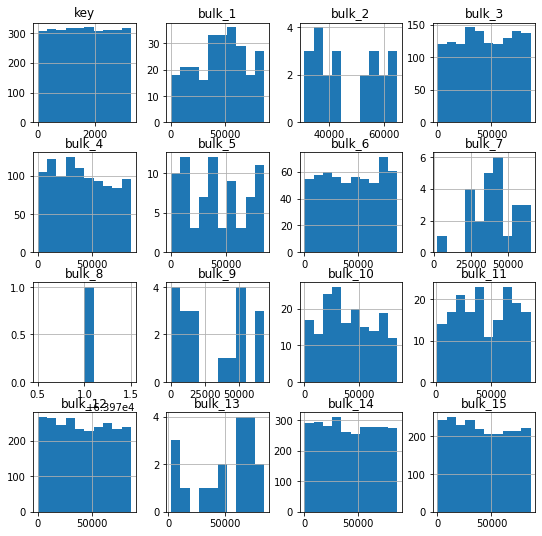

In [75]:
get_info_2(data_bulk_time)

Из полученных данных видно, что значение времени в секундах лежат в адекватном диапазоне от min 1 до 86 370, что укладывается в 24 часа (24 часа в секундах = 86400). Распределение количества имеющихся значений времмени по столбцам соответсвет распределению в таблице data_bulk.

#### Удалим столбец bulk_8, т.к. в нем только одно значение

In [76]:
data_bulk_time = data_bulk_time.drop('bulk_8', axis=1)
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_9   19 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2450 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2806 non-null   float64
 14  bulk_15  2248 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


#### Посмотрим количество уникальных значений в столбце key

In [77]:
print('Количество уникальных значений key:', len(data_bulk_time['key'].unique()))

Количество уникальных значений key: 3129


Убедились, что все значения key в датасете уникальные

#### Найдем время обработки, чтобы понять, нет ли анамалий.

В столбце time_begin_bulk будем сохранять минимальное время в строке, а в столбце time_end_bulk - максимальное время в строке

In [78]:
data_bulk_time['time_begin_bulk'] = data_bulk_time[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']].min(axis=1)
data_bulk_time['time_end_bulk'] = data_bulk_time[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']].max(axis=1)

In [79]:
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_begin_bulk,time_end_bulk
0,1,NaN,NaN,NaN,40890.0,NaN,NaN,NaN,NaN,NaN,NaN,39832.0,NaN,39832.0,39832.0,39832.0,40890.0
1,2,NaN,NaN,NaN,42398.0,NaN,NaN,NaN,NaN,NaN,NaN,42020.0,NaN,42020.0,42020.0,42020.0,42398.0
2,3,NaN,NaN,NaN,45066.0,NaN,NaN,NaN,NaN,NaN,NaN,43780.0,NaN,43780.0,43780.0,43780.0,45066.0
3,4,NaN,NaN,NaN,46123.0,NaN,NaN,NaN,NaN,NaN,NaN,45684.0,NaN,45684.0,45684.0,45684.0,46123.0
4,5,NaN,NaN,NaN,47930.0,NaN,NaN,NaN,NaN,NaN,NaN,47576.0,NaN,47576.0,47576.0,47576.0,47930.0


In [80]:
data_bulk_time.query('time_begin_bulk > time_end_bulk')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_begin_bulk,time_end_bulk


In [81]:
data_bulk_time['full_time_bulk'] = data_bulk_time['time_end_bulk'] - data_bulk_time['time_begin_bulk']

In [82]:
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_begin_bulk,time_end_bulk,full_time_bulk
0,1,NaN,NaN,NaN,40890.0,NaN,NaN,NaN,NaN,NaN,NaN,39832.0,NaN,39832.0,39832.0,39832.0,40890.0,1058.0
1,2,NaN,NaN,NaN,42398.0,NaN,NaN,NaN,NaN,NaN,NaN,42020.0,NaN,42020.0,42020.0,42020.0,42398.0,378.0
2,3,NaN,NaN,NaN,45066.0,NaN,NaN,NaN,NaN,NaN,NaN,43780.0,NaN,43780.0,43780.0,43780.0,45066.0,1286.0
3,4,NaN,NaN,NaN,46123.0,NaN,NaN,NaN,NaN,NaN,NaN,45684.0,NaN,45684.0,45684.0,45684.0,46123.0,439.0
4,5,NaN,NaN,NaN,47930.0,NaN,NaN,NaN,NaN,NaN,NaN,47576.0,NaN,47576.0,47576.0,47576.0,47930.0,354.0


In [83]:
data_bulk_time['full_time_bulk'].describe()

count     3129.000000
mean      1156.337168
std       7059.209055
min          0.000000
25%        211.000000
50%        414.000000
75%        744.000000
max      86198.000000
Name: full_time_bulk, dtype: float64

Из распределения значения full_time_bulk мы видим, что есть нормальные значения, а есть явно неадеквватные (практически сутки), надо посмотреть более детально, что это за значения и при необходимости их исключить.

In [84]:
data_bulk_time.query('full_time_bulk >= 70000')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_begin_bulk,time_end_bulk,full_time_bulk
41,44,NaN,NaN,NaN,NaN,NaN,81228.0,NaN,NaN,NaN,NaN,2375.0,2375.0,80142.0,2375.0,2375.0,81228.0,78853.0
64,74,NaN,NaN,NaN,110.0,NaN,NaN,NaN,NaN,NaN,NaN,86007.0,NaN,86007.0,86007.0,110.0,86007.0,85897.0
113,126,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85615.0,NaN,85615.0,85615.0,1.0,85615.0,85614.0
216,232,NaN,NaN,NaN,NaN,93.0,NaN,NaN,NaN,NaN,NaN,85813.0,NaN,85813.0,85813.0,93.0,85813.0,85720.0
263,280,NaN,NaN,85906.0,NaN,NaN,NaN,NaN,296.0,NaN,NaN,84203.0,NaN,84203.0,NaN,296.0,85906.0,85610.0
614,641,NaN,NaN,NaN,3792.0,NaN,NaN,NaN,NaN,NaN,NaN,74523.0,74523.0,NaN,74523.0,3792.0,74523.0,70731.0
615,642,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,NaN,NaN,86175.0,NaN,86175.0,86175.0,1367.0,86175.0,84808.0
880,913,NaN,NaN,763.0,NaN,NaN,763.0,NaN,NaN,NaN,NaN,86258.0,NaN,86258.0,NaN,763.0,86258.0,85495.0
955,999,NaN,NaN,269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86189.0,NaN,86189.0,86189.0,269.0,86189.0,85920.0
1037,1082,NaN,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,85145.0,NaN,85145.0,85145.0,38.0,85145.0,85107.0


Из полученных данных видим, что такие большие значения full_time_bulk получаются из-за того, что начали процесс в конце одних суток, а продолжили в начале следующих суток. Так как таких данных немного, чтобы не создавалось ощущение обработки сутками, исключим их из данных.

In [85]:
data_bulk_time = data_bulk_time.query('full_time_bulk < 70000')
data_bulk_time.shape

(3107, 18)

Проверим распределение значений в столбце full_time_bulk после удаления строк.

In [86]:
data_bulk_time['full_time_bulk'].describe()

count     3107.000000
mean       565.841648
std        705.508063
min          0.000000
25%        209.000000
50%        413.000000
75%        737.000000
max      12201.000000
Name: full_time_bulk, dtype: float64

Из полученных данных видим, что теперь распределение более адекватное, максимальное время около 3.4 часа.

#### Заполним пропуски значением 0

In [87]:
data_bulk_time = data_bulk_time.fillna(0)
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_begin_bulk,time_end_bulk,full_time_bulk
0,1,0.0,0.0,0.0,40890.0,0.0,0.0,0.0,0.0,0.0,0.0,39832.0,0.0,39832.0,39832.0,39832.0,40890.0,1058.0
1,2,0.0,0.0,0.0,42398.0,0.0,0.0,0.0,0.0,0.0,0.0,42020.0,0.0,42020.0,42020.0,42020.0,42398.0,378.0
2,3,0.0,0.0,0.0,45066.0,0.0,0.0,0.0,0.0,0.0,0.0,43780.0,0.0,43780.0,43780.0,43780.0,45066.0,1286.0
3,4,0.0,0.0,0.0,46123.0,0.0,0.0,0.0,0.0,0.0,0.0,45684.0,0.0,45684.0,45684.0,45684.0,46123.0,439.0
4,5,0.0,0.0,0.0,47930.0,0.0,0.0,0.0,0.0,0.0,0.0,47576.0,0.0,47576.0,47576.0,47576.0,47930.0,354.0


In [88]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 0 to 3128
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3107 non-null   int64  
 1   bulk_1           3107 non-null   float64
 2   bulk_2           3107 non-null   float64
 3   bulk_3           3107 non-null   float64
 4   bulk_4           3107 non-null   float64
 5   bulk_5           3107 non-null   float64
 6   bulk_6           3107 non-null   float64
 7   bulk_7           3107 non-null   float64
 8   bulk_9           3107 non-null   float64
 9   bulk_10          3107 non-null   float64
 10  bulk_11          3107 non-null   float64
 11  bulk_12          3107 non-null   float64
 12  bulk_13          3107 non-null   float64
 13  bulk_14          3107 non-null   float64
 14  bulk_15          3107 non-null   float64
 15  time_begin_bulk  3107 non-null   float64
 16  time_end_bulk    3107 non-null   float64
 17  full_time_bulk

#### Поменяем тип столбцов с float на  int

In [89]:
data_bulk_time[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'time_begin_bulk', 'time_end_bulk', 'full_time_bulk']] = data_bulk_time[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'time_begin_bulk', 'time_end_bulk', 'full_time_bulk']].astype('int')

In [90]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 0 to 3128
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   key              3107 non-null   int64
 1   bulk_1           3107 non-null   int64
 2   bulk_2           3107 non-null   int64
 3   bulk_3           3107 non-null   int64
 4   bulk_4           3107 non-null   int64
 5   bulk_5           3107 non-null   int64
 6   bulk_6           3107 non-null   int64
 7   bulk_7           3107 non-null   int64
 8   bulk_9           3107 non-null   int64
 9   bulk_10          3107 non-null   int64
 10  bulk_11          3107 non-null   int64
 11  bulk_12          3107 non-null   int64
 12  bulk_13          3107 non-null   int64
 13  bulk_14          3107 non-null   int64
 14  bulk_15          3107 non-null   int64
 15  time_begin_bulk  3107 non-null   int64
 16  time_end_bulk    3107 non-null   int64
 17  full_time_bulk   3107 non-null   int64
dtypes: int64

#### Делаем индексами таблицы значение столбца key

In [91]:
data_bulk_time = data_bulk_time.set_index('key')
data_bulk_time.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_begin_bulk,time_end_bulk,full_time_bulk
key,,,,,,,,,,,,,,,,,
1,0,0,0,40890,0,0,0,0,0,0,39832,0,39832,39832,39832,40890,1058
2,0,0,0,42398,0,0,0,0,0,0,42020,0,42020,42020,42020,42398,378
3,0,0,0,45066,0,0,0,0,0,0,43780,0,43780,43780,43780,45066,1286
4,0,0,0,46123,0,0,0,0,0,0,45684,0,45684,45684,45684,46123,439
5,0,0,0,47930,0,0,0,0,0,0,47576,0,47576,47576,47576,47930,354


#### Переименуем столбцы

In [92]:
data_bulk_time.columns

Index(['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'time_begin_bulk', 'time_end_bulk', 'full_time_bulk'],
      dtype='object')

In [93]:
data_bulk_time.columns = ['bulk_1_t', 'bulk_2_t', 'bulk_3_t', 'bulk_4_t', 'bulk_5_t', 'bulk_6_t', 'bulk_7_t',
       'bulk_9_t', 'bulk_10_t', 'bulk_11_t', 'bulk_12_t', 'bulk_13_t', 'bulk_14_t',
       'bulk_15_t', 'time_begin_bulk', 'time_end_bulk', 'full_time_bulk']

In [94]:
data_bulk_time.head()

,bulk_1_t,bulk_2_t,bulk_3_t,bulk_4_t,bulk_5_t,bulk_6_t,bulk_7_t,bulk_9_t,bulk_10_t,bulk_11_t,bulk_12_t,bulk_13_t,bulk_14_t,bulk_15_t,time_begin_bulk,time_end_bulk,full_time_bulk
key,,,,,,,,,,,,,,,,,
1,0,0,0,40890,0,0,0,0,0,0,39832,0,39832,39832,39832,40890,1058
2,0,0,0,42398,0,0,0,0,0,0,42020,0,42020,42020,42020,42398,378
3,0,0,0,45066,0,0,0,0,0,0,43780,0,43780,43780,43780,45066,1286
4,0,0,0,46123,0,0,0,0,0,0,45684,0,45684,45684,45684,46123,439
5,0,0,0,47930,0,0,0,0,0,0,47576,0,47576,47576,47576,47930,354


### Таблица data_gas — данные о продувке сплава газом

o	Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.

In [95]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


#### Поменяем тип данных в столбце gas на  float и посмотрим данные с помощью функции get_info

In [96]:
data_gas['gas'] = data_gas['gas'].astype('float')

In [97]:
get_info(data_gas)

'Вывод первых 5-ти строк датасета'

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Количество явных дубликатов: 0
Количество пропусков:
 key    0
gas    0
dtype: int64


,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Из полученных данных видим, что дубликатов нет, пропусокв нет. Все значения объема газа положительные, но наблюдается хвост справа, поэтому рассмотрим данный признак более внимательно построив гистограмму его респределения. Также проверим количество уникальных значений в столбце key.

In [98]:
print('Количество уникальных значений key:', len(data_gas['key'].unique()))

Количество уникальных значений key: 3239


все значения key уникальные

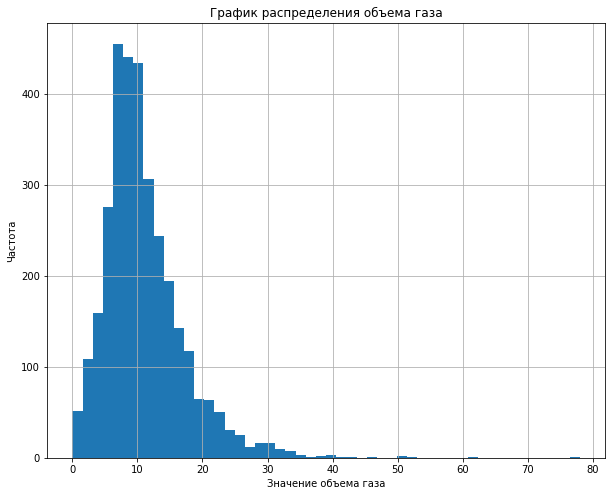

In [99]:
plt.figure(figsize=(10, 8))
data_gas['gas'].plot(kind='hist', bins=50,  grid=True)
plt.title('График распределения объема газа')
plt.ylabel('Частота')
plt.xlabel('Значение объема газа')
plt.show()

Распределение выяглядит адекватным, в среднем добавляемые объем газа лежит в от 5 до 18, но наблюдаются значения и выше 40, но носят эпизодический характер. Так как нет уверенности, что это нехарактерные значения, пока их оставим.

#### Делаем индексами таблицы значение столбца key

In [100]:
data_gas = data_gas.set_index('key')
data_gas.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


### Таблица data_temp — данные об измерениях температуры

o	Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределения признаков.

o	Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.

o	При агрегировании наблюдений используйте только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.

o	Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные.


In [101]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   mesaure_time  15907 non-null  int64  
 2   temperature   13006 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 372.9 KB


#### Поменяем тип данных в столбце temperature на float  и посмотри первичную информацию о датасете, используя функцию get_info_2

In [102]:
data_temp['temperature'] = data_temp['temperature'].astype('float')

'Вывод первых 5-ти строк датасета'

,key,mesaure_time,temperature
0,1,40578,1571.0
1,1,41153,1604.0
2,1,41351,1618.0
3,1,41401,1601.0
4,1,41439,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   mesaure_time  15907 non-null  int64  
 2   temperature   13006 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 372.9 KB


None

Количество явных дубликатов: 0
Количество пропусков:
 key                0
mesaure_time       0
temperature     2901
dtype: int64


,key,mesaure_time,temperature
count,15907.000000,15907.000000,13006.000000
mean,1607.880870,43147.684793,1591.840920
std,942.212073,25089.382854,21.375851
min,1.000000,12.000000,1191.000000
25%,790.000000,21674.000000,1581.000000
50%,1618.000000,42894.000000,1591.000000
75%,2427.000000,64953.500000,1601.000000
max,3241.000000,86394.000000,1705.000000


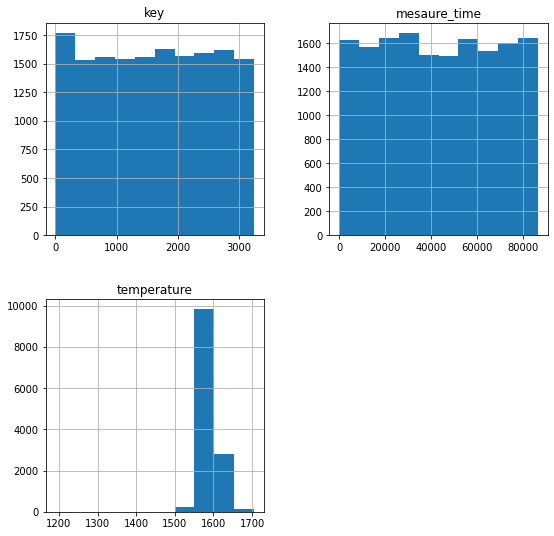

In [103]:
get_info_2(data_temp)

Из полученных данных видим, что распределение значений столбца key и mesaure_time выглядят правильными, здесь нет пропусков. В столбце temperatureесть пропуски, которые надо исключить, также надо исключить температуру ниже 1500 градусов, т.к. это анамальные значения.

In [104]:
display(data_temp.query('temperature < 1500'))
len(data_temp.query('temperature < 1500'))

,key,mesaure_time,temperature
4350,867,51660,1191.0
5978,1214,19920,1208.0
7958,1619,39834,1218.0
8913,1818,1849,1383.0
8914,1818,1900,1383.0
10127,2052,53500,1227.0
12564,2561,27255,1204.0


7

#### Удаляем строки, где температура менее 1500 (7 строк)  и нет замеров температуры (пропусков 2901).

In [105]:
data_temp = data_temp.query('temperature >= 1500')
data_temp.shape

(12999, 3)

#### Построим график распределения температуры

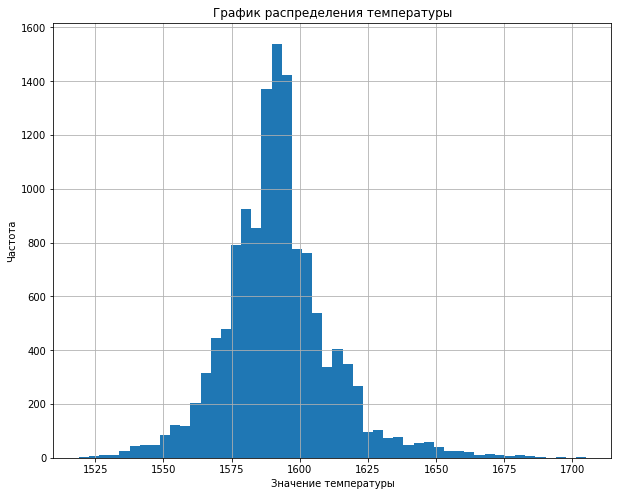

In [106]:
plt.figure(figsize=(10, 8))
data_temp['temperature'].plot(kind='hist', bins=50,  grid=True)
plt.title('График распределения температуры')
plt.ylabel('Частота')
plt.xlabel('Значение температуры')
plt.show()

Распределение напоминает нормальное 

#### Сгрупируем данные по полю key, оставив только первый и последний замер температуры.

In [107]:
data_temp_group = data_temp.groupby('key')['mesaure_time'].agg(['first', 'last']).reset_index().rename(columns=
                                                            {'first':'first_time_temp','last':'last_time_temp'})


data_temp_group.head()


,key,first_time_temp,last_time_temp
0,1,40578,41439
1,2,41847,43152
2,3,43997,45297
3,4,46377,46765
4,5,48199,48961


In [108]:
data_temp_group.shape

(3215, 3)

#### Проверим, чтобы не было ситуации, когда first_time_temp была больше (начали нагрев в конце суток, продолжили на следующие) или равна last_time_temp (в этом случае у нас один замер)

In [109]:
data_temp_group.query('first_time_temp >= last_time_temp')

,key,first_time_temp,last_time_temp
17,18,84138,509
41,44,80024,4397
42,45,83196,1573
43,46,86083,11693
71,74,85861,1182
...,...,...,...
3210,3237,81844,81844
3211,3238,84631,84631
3212,3239,5507,5507
3213,3240,9541,9541


#### Удаляем строки, где first_time_temp была больше или равна last_time_temp

In [110]:
data_temp_group = data_temp_group.query('first_time_temp < last_time_temp')
data_temp_group.shape

(2421, 3)

#### Теперь добавим к таблице значение температуры при первом замере и при последнем замере

In [111]:
data_temp_group = data_temp_group.merge(data_temp, left_on=['key', 'first_time_temp'], 
                              right_on=['key', 'mesaure_time']).rename(columns={'temperature':'start_temperature'})
data_temp_group = data_temp_group.merge(data_temp, left_on=['key', 'last_time_temp'], 
                              right_on=['key', 'mesaure_time']).rename(columns={'temperature':'finish_temperature'})



In [112]:
data_temp_group.head()

,key,first_time_temp,last_time_temp,mesaure_time_x,start_temperature,mesaure_time_y,finish_temperature
0,1,40578,41439,40578,1571.0,41439,1613.0
1,2,41847,43152,41847,1581.0,43152,1602.0
2,3,43997,45297,43997,1596.0,45297,1599.0
3,4,46377,46765,46377,1601.0,46765,1625.0
4,5,48199,48961,48199,1576.0,48961,1602.0


In [113]:
data_temp_group.shape

(2421, 7)

#### Удаляем ненужные столбцы mesaure_time_x и mesaure_time_y

In [114]:
data_temp_group = data_temp_group.drop(['mesaure_time_x', 'mesaure_time_y'], axis=1)

In [115]:
data_temp_group.head()

,key,first_time_temp,last_time_temp,start_temperature,finish_temperature
0,1,40578,41439,1571.0,1613.0
1,2,41847,43152,1581.0,1602.0
2,3,43997,45297,1596.0,1599.0
3,4,46377,46765,1601.0,1625.0
4,5,48199,48961,1576.0,1602.0


#### Делаем индексами таблицы значение столбца key

In [116]:
data_temp_group  = data_temp_group.set_index('key')
data_temp_group.head()

,first_time_temp,last_time_temp,start_temperature,finish_temperature
key,,,,
1,40578,41439,1571.0,1613.0
2,41847,43152,1581.0,1602.0
3,43997,45297,1596.0,1599.0
4,46377,46765,1601.0,1625.0
5,48199,48961,1576.0,1602.0


#### Построим графики распределения температуры

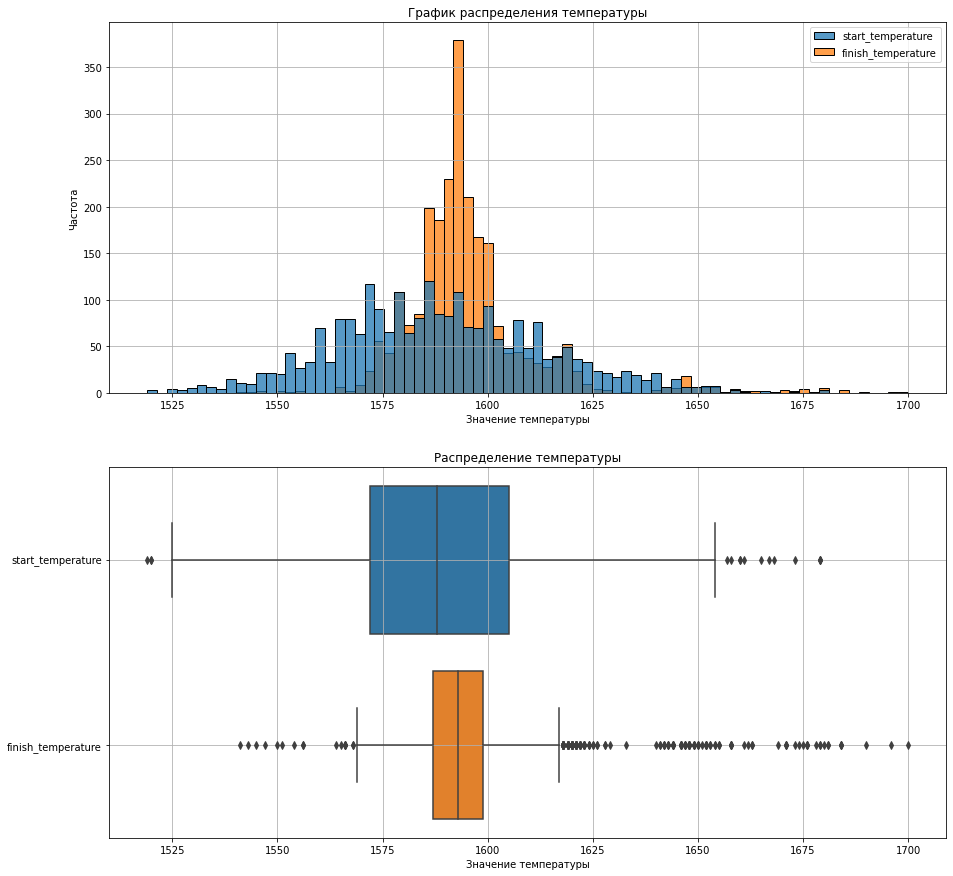

In [117]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
sns.histplot(data=data_temp_group[['start_temperature', 'finish_temperature']])
plt.grid()
plt.title('График распределения температуры')
plt.ylabel('Частота')
plt.xlabel('Значение температуры')
plt.subplot(2,1,2)
sns.boxplot(data=data_temp_group[['start_temperature', 'finish_temperature']], orient='horizontal')
plt.grid()
plt.title('Распределение температуры')
plt.xlabel('Значение температуры')
plt.show()


Распределение начальной температуры имеет более широкий диапазон изменений, чем конечной температуры, среднее значение начальной температуры ниже, чем среднее значение конечной температуры. И в целом диапазон значений корнечной температуры сдвинут вправо относительно диаразона значений начальной температуры.

### Таблица data_wire — данные об объёме проволочных материалов

o	Обработайте пропуски. Пропуск означает, что материал не добавляли в эту партию.

In [118]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


#### Переименуем столбцы и изменим тип данных на float

In [119]:
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

In [120]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
data_wire[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']] = data_wire[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']].astype('float')

#### Получим общую информацию о датасете с помощью функции get_info_2

'Вывод первых 5-ти строк датасета'

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Количество явных дубликатов: 0
Количество пропусков:
 key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


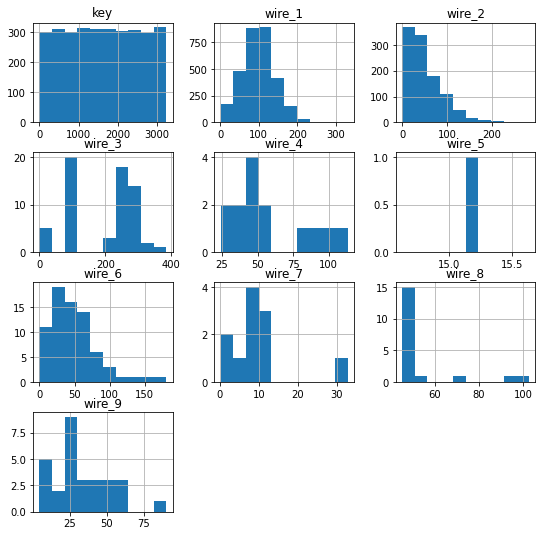

In [122]:
get_info_2(data_wire)

Из полученных данных видим, что в целом значения объемов проволочных материалов выглядят адекватными, значения все положительные, каких-то сино выделяющихся значений нет. Проволочный материал wire_5 добавляли только один раз, исключим данный столбец. Наиболее часто добавляют материалы wire_1 и  wire_2, все остальные материалы добавляют редко.

In [123]:
data_wire = data_wire.drop('wire_5', axis=1)
data_wire.shape

(3081, 9)

#### Проверим количество уникальных значений в столбце key

In [124]:
print('Количество уникальных значений key:', len(data_wire['key'].unique()))

Количество уникальных значений key: 3081


Все значения уникальны

#### Обработаем пропуски

Отсутствие значений говорит о том, что материал не подавался, следовательно добавим 0 вместо пропусков.

In [125]:
data_wire = data_wire.fillna(0)
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_6  3081 non-null   float64
 6   wire_7  3081 non-null   float64
 7   wire_8  3081 non-null   float64
 8   wire_9  3081 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


Пропусков нет.

#### Делаем индексами таблицы значение столбца key

In [127]:
data_wire = data_wire.set_index('key')
data_wire.head()

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


### Таблица data_wire_time — данные о времени подачи проволочных материалов

o	Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.

o	Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.


#### Получим первоначальные данные о датасете с помощью функции get_info_2

'Вывод первых 5-ти строк датасета'

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,40301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,42370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,44027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,46085.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,47895.0,48726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Количество явных дубликатов: 0
Количество пропусков:
 key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.0,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,42735.153846,43230.911956,49531.634921,42585.428571,57667.0,48459.643836,51286.727273,30442.105263,44411.758621
std,932.996726,25073.158051,25041.035684,21498.409720,11600.747567,NaN,23273.776688,12977.697917,24058.291684,28838.484785
min,1.000000,37.000000,116.000000,5342.000000,26128.000000,57667.0,273.000000,36116.000000,212.000000,1271.000000
25%,823.000000,21010.500000,20843.500000,33002.000000,33543.250000,57667.0,33622.000000,42373.500000,9363.500000,19349.000000
50%,1619.000000,42097.000000,44231.000000,52837.000000,40741.000000,57667.0,51147.000000,45720.000000,18865.000000,37560.000000
75%,2434.000000,64557.500000,65067.500000,65396.000000,50469.750000,57667.0,65403.000000,63399.000000,51245.000000,74939.000000
max,3241.000000,86395.000000,86334.000000,84466.000000,65372.000000,57667.0,85660.000000,71176.000000,68287.000000,86356.000000


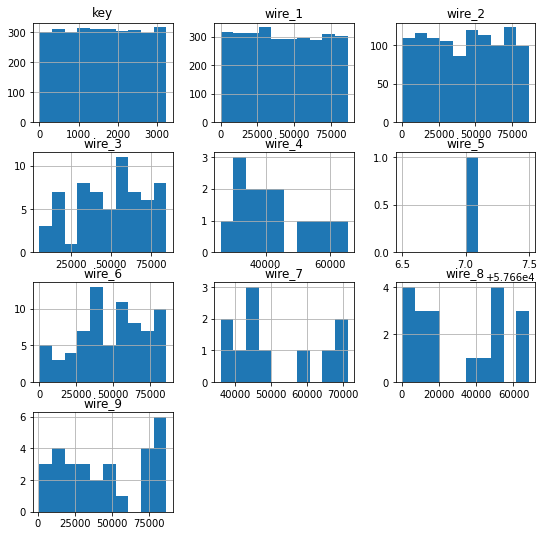

In [128]:
get_info_2(data_wire_time)

Из полученных данных видно, что значение времени в секундах лежат в адекватном диапазоне от min 1 до 86395. что укладывается в 24 часа (24 часа в секундах = 86400). Распределение количества имеющихся значений времмени по столбцам соответсвет распределению в таблице data_wire.

#### Удалим столбец wire_5, т.к. в нем только одно значение

In [129]:
data_wire_time = data_wire_time.drop('wire_5', axis=1)
data_wire_time.shape

(3081, 9)

#### Проверим количество уникальных значений в столбце key

In [130]:
print('Количество уникальных значений key:', len(data_wire_time['key'].unique()))

Количество уникальных значений key: 3081


Все значения уникальны

#### Найдем время обработки, чтобы понять, нет ли анамалий.

In [131]:
data_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9'],
      dtype='object')

В столбце time_begin_wire будем сохранять минимальное время в строке, а в столбце time_end_wire - максимальное время в строке

In [132]:
data_wire_time['time_begin_wire'] = data_wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9']].min(axis=1)
data_wire_time['time_end_wire'] = data_wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9']].max(axis=1)

In [133]:
data_wire_time['full_time_wire'] = data_wire_time['time_end_wire'] - data_wire_time['time_begin_wire']

In [134]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,time_begin_wire,time_end_wire,full_time_wire
0,1,40301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40301.0,40301.0,0.0
1,2,42370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42370.0,42370.0,0.0
2,3,44027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44027.0,44027.0,0.0
3,4,46085.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46085.0,46085.0,0.0
4,5,47895.0,48726.0,NaN,NaN,NaN,NaN,NaN,NaN,47895.0,48726.0,831.0


In [135]:
data_wire_time['full_time_wire'].describe()

count     3081.000000
mean       323.691659
std       3806.407968
min          0.000000
25%          0.000000
50%          0.000000
75%         80.000000
max      86046.000000
Name: full_time_wire, dtype: float64

Посмотрим значения, которые больше 70000 

In [136]:
data_wire_time.query('full_time_wire > 20000')

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,time_begin_wire,time_end_wire,full_time_wire
257,280,85241.0,85924.0,NaN,NaN,NaN,NaN,212.0,NaN,212.0,85924.0,85712.0
389,421,86304.0,598.0,NaN,NaN,NaN,NaN,NaN,NaN,598.0,86304.0,85706.0
701,745,86162.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,116.0,86162.0,86046.0
1224,1292,85254.0,676.0,NaN,NaN,NaN,NaN,NaN,NaN,676.0,85254.0,84578.0
1785,1875,85887.0,338.0,NaN,NaN,NaN,NaN,NaN,NaN,338.0,85887.0,85549.0
2591,2725,85927.0,NaN,NaN,NaN,273.0,NaN,NaN,NaN,273.0,85927.0,85654.0


In [137]:
len(data_wire_time.query('full_time_wire > 20000'))

6

Удаляем эти значения. т.к. их немного

In [138]:
data_wire_time = data_wire_time.query('full_time_wire < 20000')
data_wire_time.shape

(3075, 12)

#### Заполняем пропуски 0

In [139]:
data_wire_time = data_wire_time.fillna(0)
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,time_begin_wire,time_end_wire,full_time_wire
0,1,40301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40301.0,40301.0,0.0
1,2,42370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42370.0,42370.0,0.0
2,3,44027.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44027.0,44027.0,0.0
3,4,46085.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46085.0,46085.0,0.0
4,5,47895.0,48726.0,0.0,0.0,0.0,0.0,0.0,0.0,47895.0,48726.0,831.0


In [140]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075 entries, 0 to 3080
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3075 non-null   int64  
 1   wire_1           3075 non-null   float64
 2   wire_2           3075 non-null   float64
 3   wire_3           3075 non-null   float64
 4   wire_4           3075 non-null   float64
 5   wire_6           3075 non-null   float64
 6   wire_7           3075 non-null   float64
 7   wire_8           3075 non-null   float64
 8   wire_9           3075 non-null   float64
 9   time_begin_wire  3075 non-null   float64
 10  time_end_wire    3075 non-null   float64
 11  full_time_wire   3075 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 312.3 KB


Пропусков нет

#### Меняем формат столбцов с float на integer

In [141]:
data_wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9']] = data_wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9']].astype('int')

#### Делаем индексами таблицы значение столбца key

In [142]:
data_wire_time = data_wire_time.set_index('key')
display(data_wire_time.head())
data_wire_time.info()

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,time_begin_wire,time_end_wire,full_time_wire
key,,,,,,,,,,,
1,40301,0,0,0,0,0,0,0,40301.0,40301.0,0.0
2,42370,0,0,0,0,0,0,0,42370.0,42370.0,0.0
3,44027,0,0,0,0,0,0,0,44027.0,44027.0,0.0
4,46085,0,0,0,0,0,0,0,46085.0,46085.0,0.0
5,47895,48726,0,0,0,0,0,0,47895.0,48726.0,831.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075 entries, 1 to 3241
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   wire_1           3075 non-null   int64  
 1   wire_2           3075 non-null   int64  
 2   wire_3           3075 non-null   int64  
 3   wire_4           3075 non-null   int64  
 4   wire_6           3075 non-null   int64  
 5   wire_7           3075 non-null   int64  
 6   wire_8           3075 non-null   int64  
 7   wire_9           3075 non-null   int64  
 8   time_begin_wire  3075 non-null   float64
 9   time_end_wire    3075 non-null   float64
 10  full_time_wire   3075 non-null   float64
dtypes: float64(3), int64(8)
memory usage: 288.3 KB


#### Переименуем столбцы

In [143]:
data_wire_time.columns = ['wire_1_t', 'wire_2_t', 'wire_3_t', 'wire_4_t', 'wire_6_t',
       'wire_7_t', 'wire_8_t', 'wire_9_t', 'time_begin_wire', 'time_end_wire ', 'full_time_wire']

In [144]:
data_wire_time.head()

,wire_1_t,wire_2_t,wire_3_t,wire_4_t,wire_6_t,wire_7_t,wire_8_t,wire_9_t,time_begin_wire,time_end_wire,full_time_wire
key,,,,,,,,,,,
1,40301,0,0,0,0,0,0,0,40301.0,40301.0,0.0
2,42370,0,0,0,0,0,0,0,42370.0,42370.0,0.0
3,44027,0,0,0,0,0,0,0,44027.0,44027.0,0.0
4,46085,0,0,0,0,0,0,0,46085.0,46085.0,0.0
5,47895,48726,0,0,0,0,0,0,47895.0,48726.0,831.0


**Вывод**:
На данном этапе был проведенн исследовательский анализ таблиц с данными.

**1. Таблица data_arc - данные об электродах:**

  - в столбце реактивной мощности было найдено аномальное отрицательное значение, его заменили на корректное, исходя из связи межу активной и реактивной можности (высокая корреляция между данными признаками). В среднем реактивная мощность отличается от реактивной на 0.75.
  
  - были добавлены новые признаки: полная (кажущаяся можность $${\displaystyle |S|={\sqrt {P ^{2} + Q ^{2}}}},$$), время нагрева, energy (определили путем умножения полной мощности на время нагрева), коэффициента можности (активной мощности к кажущейся мощности)
  
  - далее агрегировали данные по ключу key (номеру партии) и получили при этом еще дополнительный признак, количество нагревов сплава.
  
  
**2.  Таблица data_bulk — данные об объёме сыпучих материалов:**

 - был удален столбце bulk_8 - так как в данном столбце было только одно значение (данный компонент добавляли только один раз);
 
 - также было выявлено одно очень сильно выделеяющееся значение объема в столбце bulk_12, то данная строка была удалена;
 
 - пропуски в столбцах были заменены на 0, т.к. отсутствие данных, говорило о том, что данные компоненты в сплав не добавлялись.
 
 
**3. Таблица data_bulk_time — данные о времени подачи сыпучих материалов**

- здесь также был удален столбец bulk_8, т.к. содержал только одно значение;

- было определено время начала и время окнчания обработки, а также время обработки. Значения с временем обработки в районе суток были удалены;

- пропуски были заполнены 0.

**4. Таблица data_gas — данные о продувке сплава газом**

Проверили распределение признака объем газа, распределние признака выглядит адекватным, есть длинный хвост справа, но эти значения удалять не стали, т.к. нет уверенности, что они ошибочны и от заказчика не было дополнительной информации, что какие-то значения могут быть некорректными.

**5. Таблица data_temp — данные об измерениях температуры**

- удалили строки, где температура ниже 1500, так как заказчиком была предоставлена информация, что температуры ниже 1500 являются анамальными

- сгрупировали данные по полю key, оставив только первый и последний замер температуры. Последний замер температуры является целевым признаком, который нам надо предсказать. Все остальные замеры температуры, кроме первого и последнего, могут являться утечкой целевого признака.

- проверили условие, чтобы время первого замера температуры не было равно или не превышало значение времени конечного замера температуры, удалили строки, где данное требование нарушалось.

В итоге получили, что распределение начальной температуры имеет более широкий диапазон изменений, чем конечной температуры, среднее значение начальной температуры ниже, чем среднее значение конечной температуры. И в целом диапазон значений корнечной температуры сдвинут вправо относительно диапазона значений начальной температуры.

**6. Таблица data_wire — данные об объёме проволочных материалов**

- удалили столбец wire_5 так как тут только одно значение

- пропуски заполнили 0, т.к. отсутсвие данных готоврит о том, что данный компонент не добавлялся.

**7. Таблица data_wire_time — данные о времени подачи проволочных материалов**

- также удалили столбце wire_5, т.к. в нем только одно значение

- было определено время начала и время окнчания обработки, а также время обработки. Значения с временем обработки в районе суток были удалены;

- пропуски были заполнены 0.

### Объединяем таблицы по ключу key

o  Каждой партии соответствует одно наблюдение.
o  Во все партии добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался.


In [145]:
data_total = data_temp_group.join([data_arc_grouped, data_bulk, data_bulk_time, data_gas, data_wire, data_wire_time], how='inner',  rsuffix='_y')

#### Посмотрим, что у нас получилось, используя функцию get_info

In [146]:
get_info(data_total)

'Вывод первых 5-ти строк датасета'

,first_time_temp,last_time_temp,start_temperature,finish_temperature,count_heat,begin_heat,end_heat,active_power,reactive_power,time_heat,...,wire_2_t,wire_3_t,wire_4_t,wire_6_t,wire_7_t,wire_8_t,wire_9_t,time_begin_wire,time_end_wire,full_time_wire
key,,,,,,,,,,,,,,,,,,,,,
1,40578,41439,1571.0,1613.0,5,39734,41317,0.975629,0.636648,1098,...,0,0,0,0,0,0,0,40301.0,40301.0,0.0
2,41847,43152,1581.0,1602.0,4,41654,42798,0.763150,0.499528,811,...,0,0,0,0,0,0,0,42370.0,42370.0,0.0
3,43997,45297,1596.0,1599.0,5,43614,45139,0.505176,0.319815,655,...,0,0,0,0,0,0,0,44027.0,44027.0,0.0
4,46377,46765,1601.0,1625.0,4,45577,46670,0.802313,0.515074,741,...,0,0,0,0,0,0,0,46085.0,46085.0,0.0
5,48199,48961,1576.0,1602.0,4,47473,48835,0.836793,0.563161,869,...,48726,0,0,0,0,0,0,47895.0,48726.0,831.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2273 entries, 1 to 2499
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_time_temp     2273 non-null   int64  
 1   last_time_temp      2273 non-null   int64  
 2   start_temperature   2273 non-null   float64
 3   finish_temperature  2273 non-null   float64
 4   count_heat          2273 non-null   int64  
 5   begin_heat          2273 non-null   int64  
 6   end_heat            2273 non-null   int64  
 7   active_power        2273 non-null   float64
 8   reactive_power      2273 non-null   float64
 9   time_heat           2273 non-null   int64  
 10  full_power          2273 non-null   float64
 11  koef_power          2273 non-null   float64
 12  energy              2273 non-null   float64
 13  bulk_1              2273 non-null   int64  
 14  bulk_2              2273 non-null   int64  
 15  bulk_3              2273 non-null   int64  
 16  bulk_4

None

Количество явных дубликатов: 0
Количество пропусков:
 first_time_temp       0
last_time_temp        0
start_temperature     0
finish_temperature    0
count_heat            0
                     ..
wire_8_t              0
wire_9_t              0
time_begin_wire       0
time_end_wire         0
full_time_wire        0
Length: 64, dtype: int64


,first_time_temp,last_time_temp,start_temperature,finish_temperature,count_heat,begin_heat,end_heat,active_power,reactive_power,time_heat,...,wire_2_t,wire_3_t,wire_4_t,wire_6_t,wire_7_t,wire_8_t,wire_9_t,time_begin_wire,time_end_wire,full_time_wire
count,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,...,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000
mean,41606.561813,43470.027277,1587.358117,1593.375275,4.669600,41442.784866,43257.399032,0.668225,0.498827,801.828861,...,15069.290365,959.807743,228.938847,936.256049,101.199296,127.010559,447.988121,42155.092389,42301.763748,146.671359
std,24351.689515,24410.972817,23.608534,11.169290,1.574006,24361.252123,24418.893553,0.197689,0.147841,332.449945,...,25191.764447,7774.817232,3255.907535,7201.156248,2470.071198,2471.778605,5127.464031,24367.260733,24383.770615,560.979441
min,68.000000,746.000000,1519.000000,1541.000000,1.000000,12.000000,651.000000,0.186226,0.130062,57.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,138.000000,166.000000,0.000000
25%,20562.000000,22327.000000,1571.000000,1587.000000,4.000000,20329.000000,22143.000000,0.524355,0.391618,578.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21366.000000,21395.000000,0.000000
50%,41198.000000,43088.000000,1587.000000,1593.000000,5.000000,40982.000000,42840.000000,0.642185,0.485992,776.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41924.000000,42082.000000,0.000000
75%,62087.000000,64059.000000,1603.000000,1598.000000,6.000000,61854.000000,63825.000000,0.791791,0.592351,991.000000,...,23599.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62688.000000,62912.000000,79.000000
max,85304.000000,86394.000000,1660.000000,1653.000000,16.000000,86275.000000,86249.000000,1.421416,1.134983,4189.000000,...,85548.000000,84466.000000,65372.000000,85492.000000,71176.000000,68287.000000,83718.000000,85576.000000,85576.000000,18756.000000


#### Время замера конечной температуры last_time_temp должено быть самым последним значением времени для данной партии, проверим это условие

#### Выберем столбцы, в которых фигурирует начальное и конечное время обработки

In [147]:
data_total.columns

Index(['first_time_temp', 'last_time_temp', 'start_temperature',
       'finish_temperature', 'count_heat', 'begin_heat', 'end_heat',
       'active_power', 'reactive_power', 'time_heat', 'full_power',
       'koef_power', 'energy', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
       'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'bulk_1_t', 'bulk_2_t', 'bulk_3_t',
       'bulk_4_t', 'bulk_5_t', 'bulk_6_t', 'bulk_7_t', 'bulk_9_t', 'bulk_10_t',
       'bulk_11_t', 'bulk_12_t', 'bulk_13_t', 'bulk_14_t', 'bulk_15_t',
       'time_begin_bulk', 'time_end_bulk', 'full_time_bulk', 'gas', 'wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9',
       'wire_1_t', 'wire_2_t', 'wire_3_t', 'wire_4_t', 'wire_6_t', 'wire_7_t',
       'wire_8_t', 'wire_9_t', 'time_begin_wire', 'time_end_wire ',
       'full_time_wire'],
      dtype='object')

In [148]:
time_columns = ['first_time_temp', 'last_time_temp', 'begin_heat', 'end_heat',       
                  'time_begin_bulk', 'time_end_bulk', 'time_begin_wire', 'time_end_wire ']
       

In [149]:
data_total['max_time'] = (data_total[time_columns].max(axis=1)).astype(int)



In [150]:
data_total['max_time'].describe()

count     2273.000000
mean     43588.202816
std      24412.929340
min       1318.000000
25%      22451.000000
50%      43181.000000
75%      64143.000000
max      86394.000000
Name: max_time, dtype: float64

In [151]:
data_total.query('max_time > last_time_temp')[time_columns]

,first_time_temp,last_time_temp,begin_heat,end_heat,time_begin_bulk,time_end_bulk,time_begin_wire,time_end_wire
key,,,,,,,,
11,60858,62843,60554,62947,61432,62194,62101.0,62101.0
38,58031,59197,57816,59244,58302,58816,58151.0,58634.0
43,73185,74890,72941,74971,73404,74047,73971.0,74001.0
64,59662,62806,59448,62900,60079,60305,60194.0,60270.0
69,73919,76240,73641,76339,74190,75655,74097.0,75589.0
...,...,...,...,...,...,...,...,...
2421,31610,32783,31388,32699,31772,32784,31893.0,32067.0
2425,39310,40356,39066,40478,39527,39788,39743.0,39779.0
2427,43264,44374,42938,44508,43473,43773,43660.0,43713.0


Получили 123 строки, где время последнего замера температуры меньше последнего времени какой-то из операций в отношении одной партии стали. Разница между данными очень небольшая около 2 мин. Это может объясняться тем, что после проводились еще какие-то операции или несинхронизированность в замерах времени. Так как полной уверенности нет, что это ошибочные данные, пока оставим эти значения. Уберем столбец - 'max_time'.

In [154]:
data_total = data_total.drop(['max_time'] , axis=1)

In [155]:
data_total.shape

(2273, 64)

Уберем столбцы 'begin_heat', 'end_heat', 'time_begin_bulk', 'time_end_bulk', 'time_begin_wire', 'time_end_wire '

In [156]:
data_total = data_total.drop(['begin_heat', 'end_heat',       
                  'time_begin_bulk', 'time_end_bulk', 'time_begin_wire', 'time_end_wire '], axis=1)

In [157]:
data_total.shape

(2273, 58)

In [158]:
data_total.columns

Index(['first_time_temp', 'last_time_temp', 'start_temperature',
       'finish_temperature', 'count_heat', 'active_power', 'reactive_power',
       'time_heat', 'full_power', 'koef_power', 'energy', 'bulk_1', 'bulk_2',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_1_t',
       'bulk_2_t', 'bulk_3_t', 'bulk_4_t', 'bulk_5_t', 'bulk_6_t', 'bulk_7_t',
       'bulk_9_t', 'bulk_10_t', 'bulk_11_t', 'bulk_12_t', 'bulk_13_t',
       'bulk_14_t', 'bulk_15_t', 'full_time_bulk', 'gas', 'wire_1', 'wire_2',
       'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_1_t',
       'wire_2_t', 'wire_3_t', 'wire_4_t', 'wire_6_t', 'wire_7_t', 'wire_8_t',
       'wire_9_t', 'full_time_wire'],
      dtype='object')

#### Визуализируем распределениен всех признаков в итоговой таблице

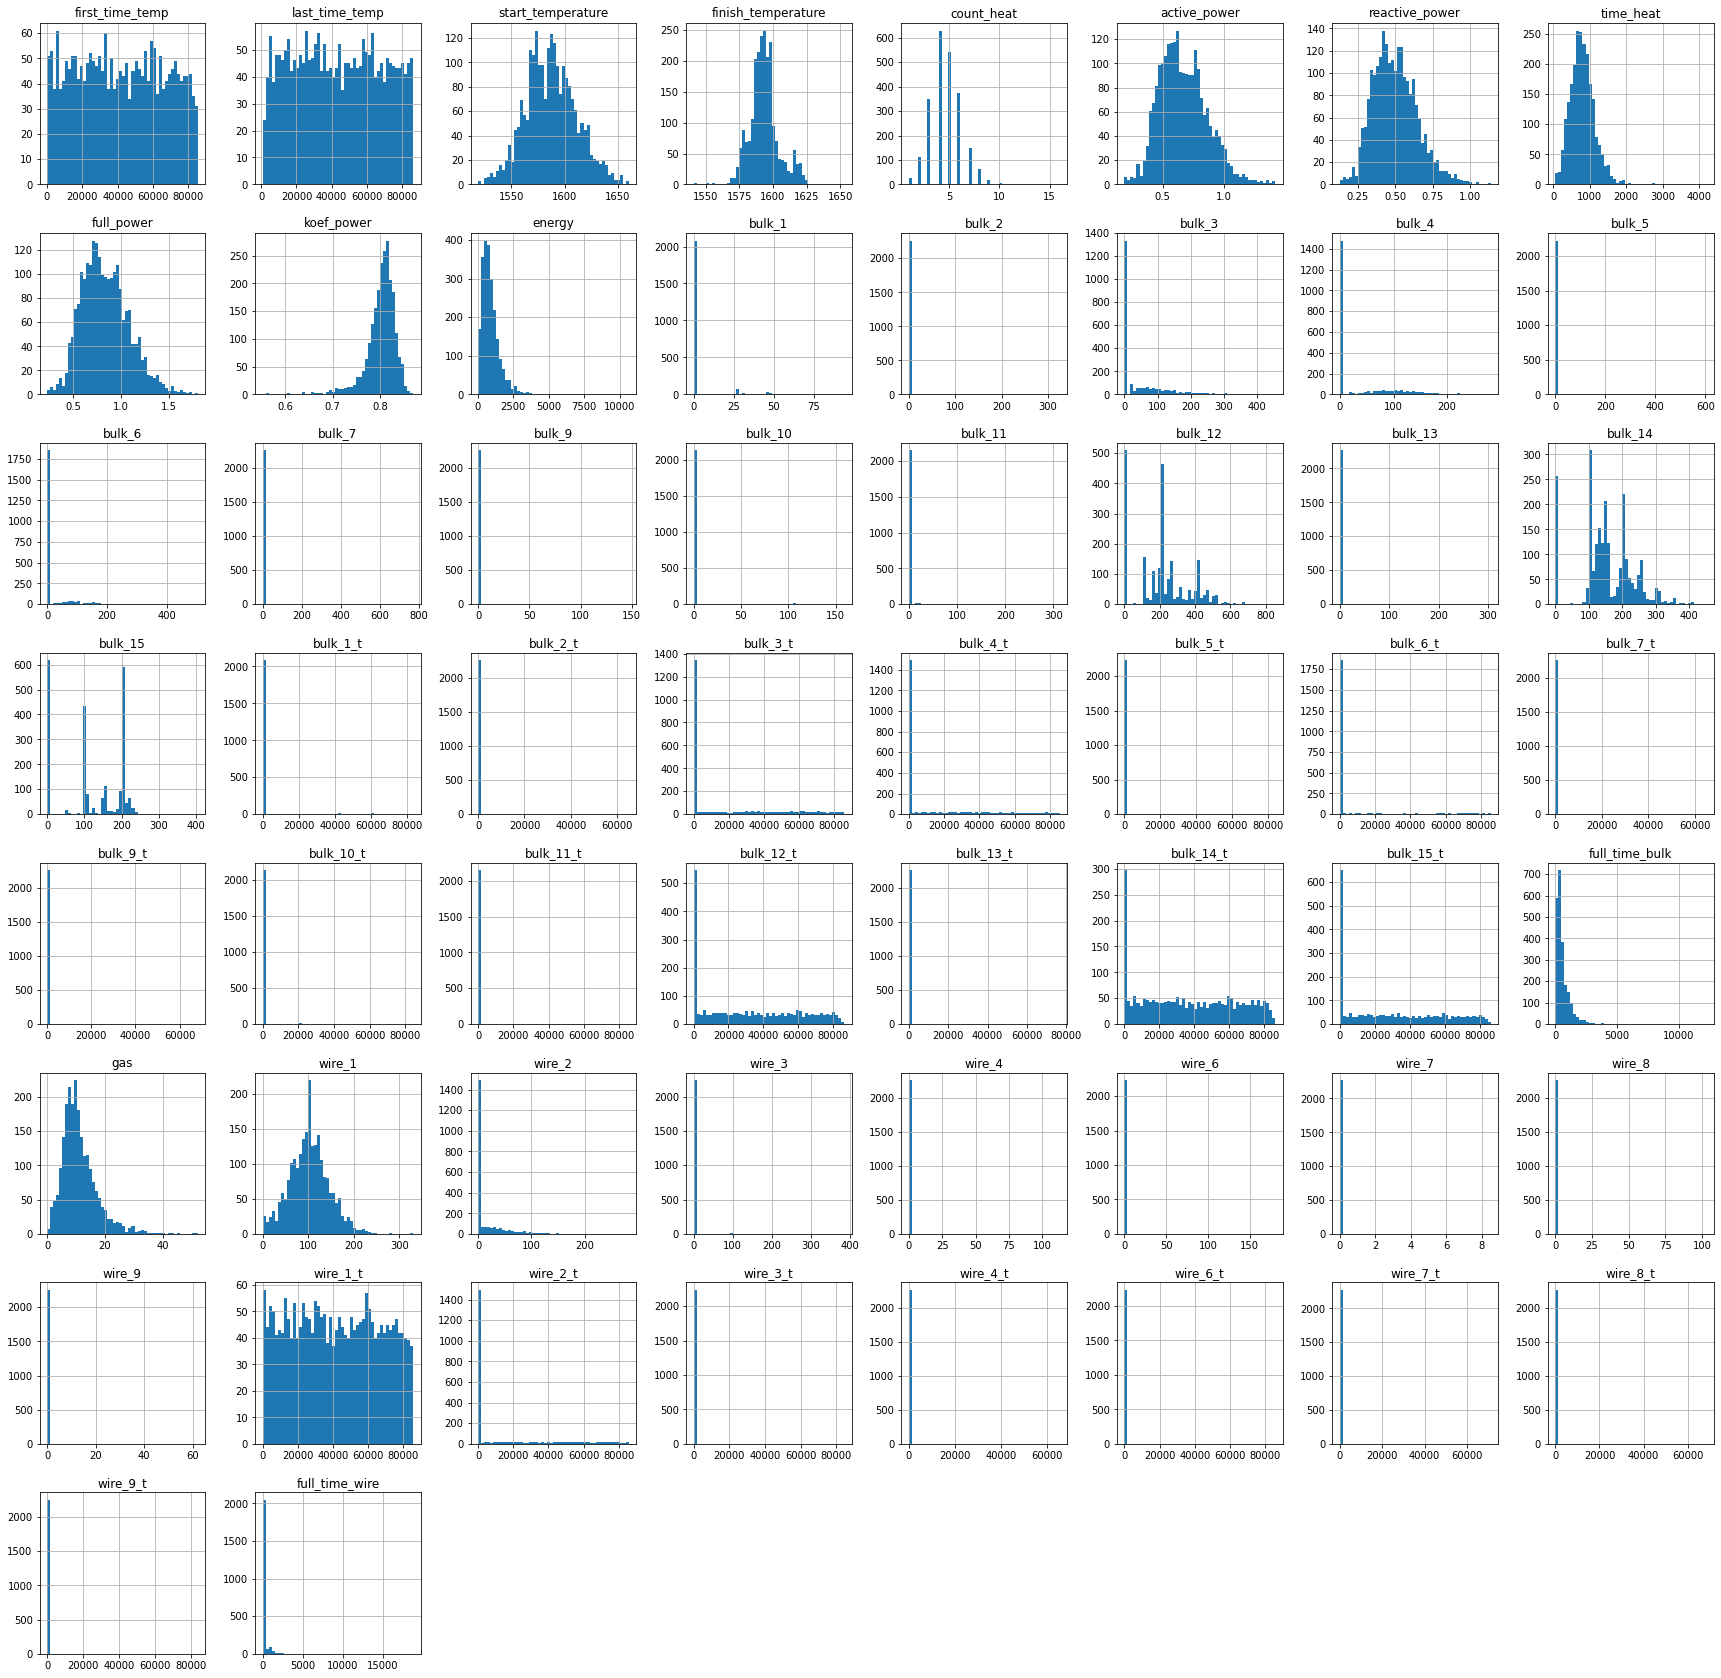

In [159]:
data_total.hist( bins=50,  grid=True, figsize=(30, 30));


В итоге у нас получилася датафрейм  размером 2150, 64. Мы получили распределение признаков, похожее на распределение полученные ранее, за исключением признаков bulk, bulk_time, wire, wire_time. Так как мы заменили пропущенные значения на 0, а ряд компонентов добавляется не часто, то получили распредления признаков, где чаше всего встречается 0. Распределение объемов компонет и времени их добавления, которые добавляются част, выглядят иначе, здесь на ряду с 0 достаточна большая частота и других значений объемов и времени.

#### Построим матрику корреляции Пирсона для признаков и визуализируем ее в seaborn

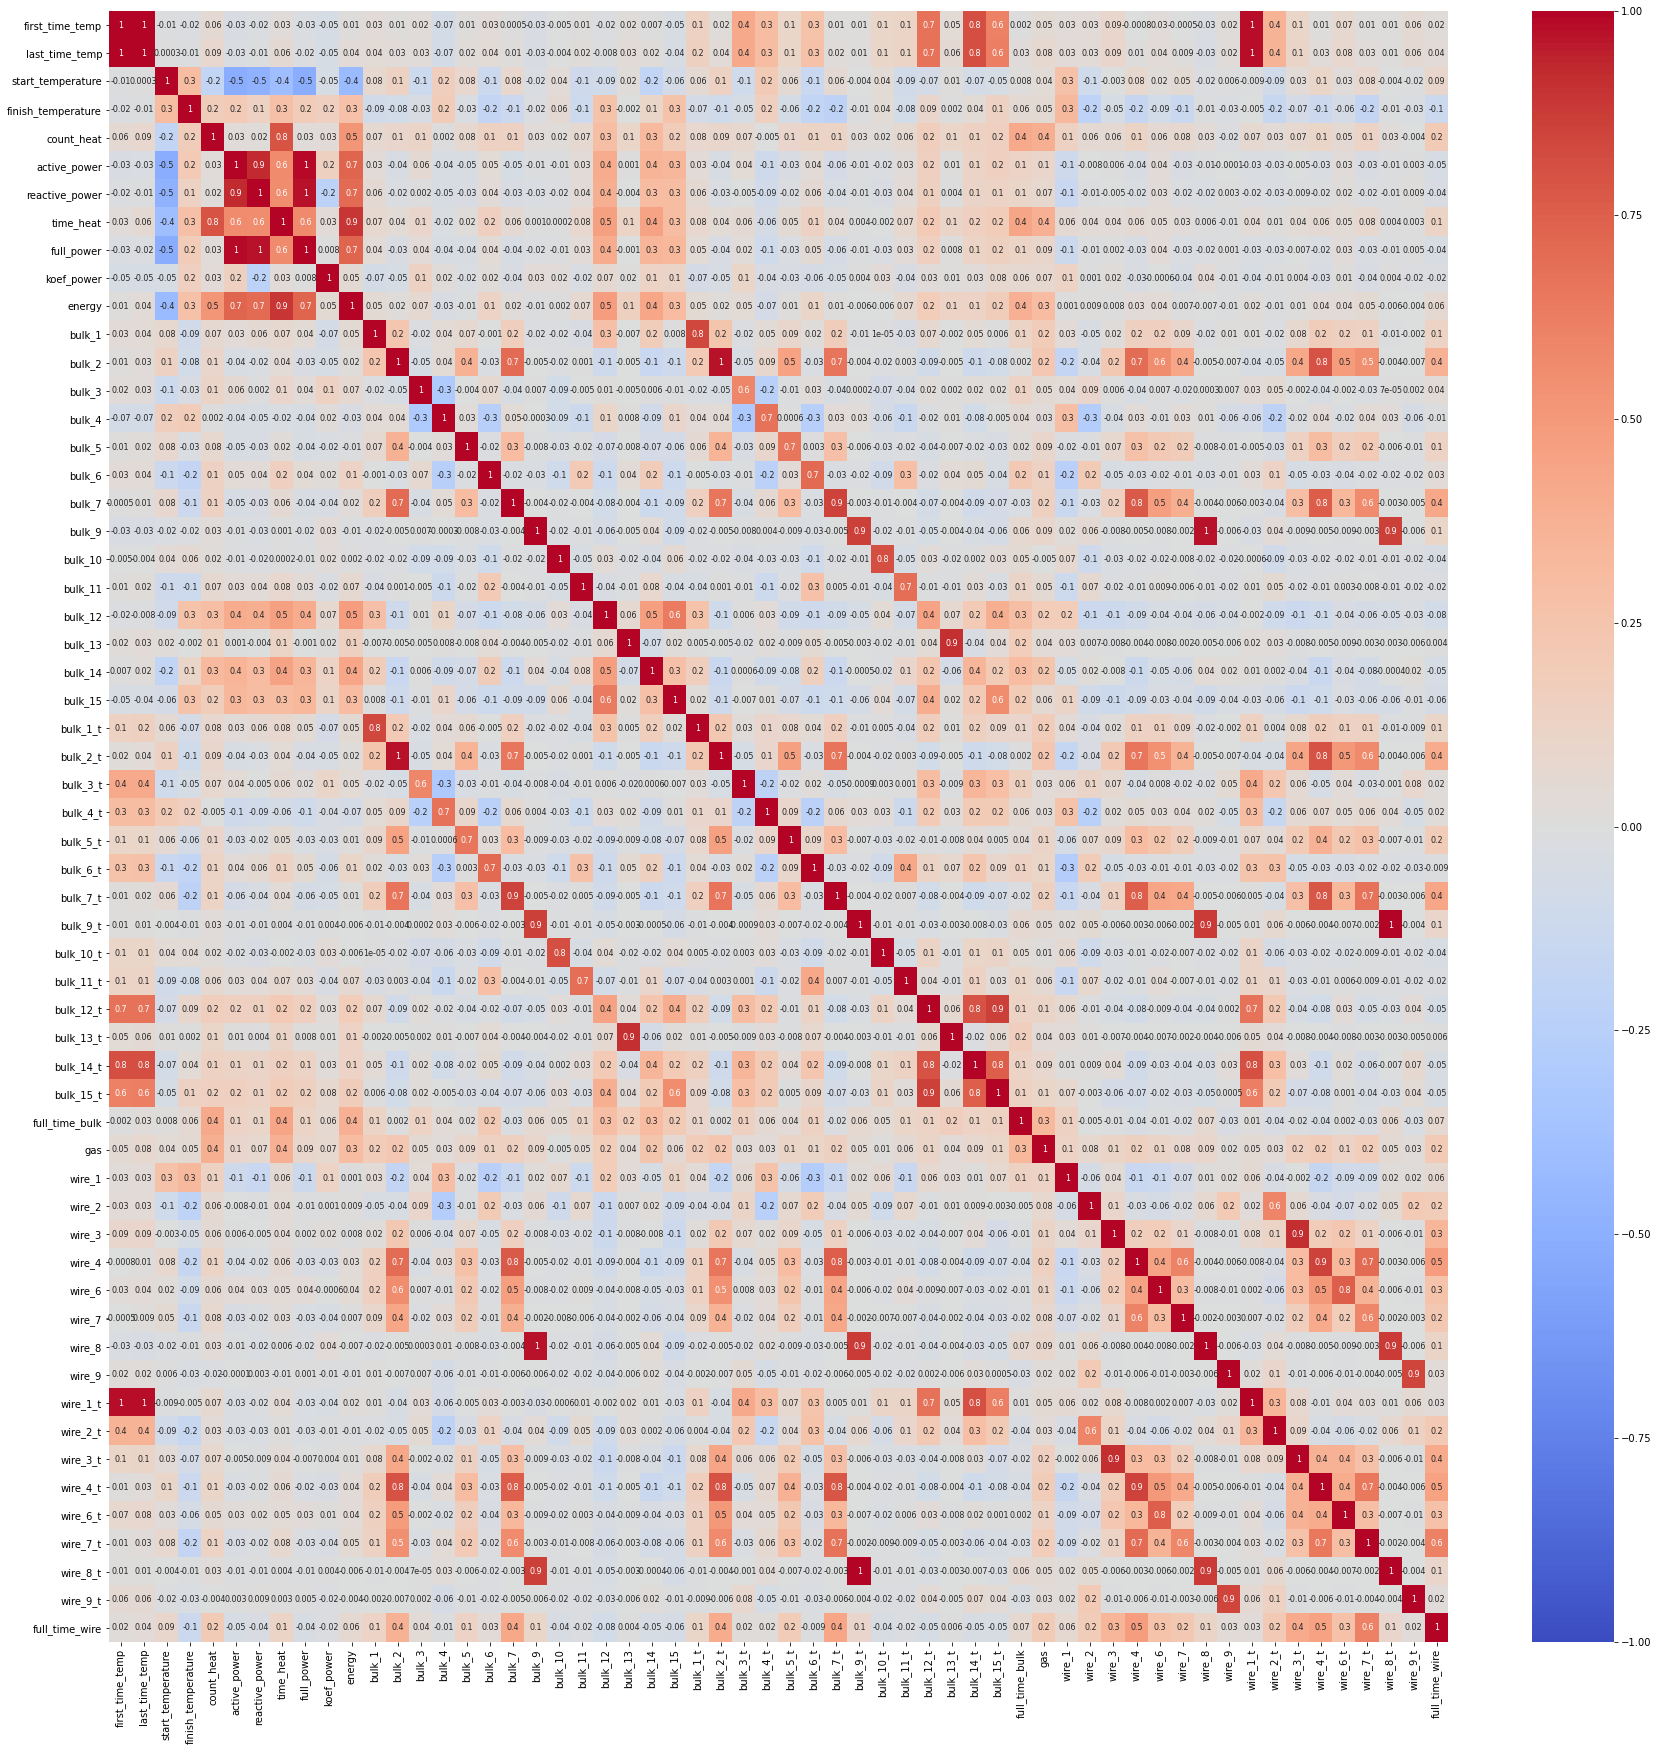

In [160]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(data_total.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', 
                annot_kws={"fontsize":8});

In [161]:
data_total.corr().unstack()[(data_total.corr().unstack() < 1) & (abs(data_total.corr().unstack()) > 0.8)]

first_time_temp  last_time_temp     0.998789
                 bulk_14_t          0.813211
                 wire_1_t           0.982322
last_time_temp   first_time_temp    0.998789
                 bulk_14_t          0.813569
                 wire_1_t           0.981614
active_power     reactive_power     0.922810
                 full_power         0.988354
reactive_power   active_power       0.922810
                 full_power         0.970445
time_heat        energy             0.897739
full_power       active_power       0.988354
                 reactive_power     0.970445
energy           time_heat          0.897739
bulk_1           bulk_1_t           0.839238
bulk_2           bulk_2_t           0.974758
                 wire_4_t           0.801105
bulk_7           bulk_7_t           0.858532
bulk_9           bulk_9_t           0.865228
                 wire_8             0.973814
                 wire_8_t           0.864173
bulk_10          bulk_10_t          0.813476
bulk_13   

Из полученных данных видим, что целевой признак сильно не коррелируется ни с одним признаком, максимальная корреляция в районе 0.2 - 0.3. Зато среди признаков есть признаки с очень высокой корреляцией, это надо учесть при обучении модлей. Например, линейные модели очень чуствительны к признакм с высокой корреляцией, поэтому надо выбирать линейные модели, которые к этому утойчивы, например Ridge, или удалить часть признаков с высокой корреляцией.

**Вывод** - На данном этапе было сделано следующее:

- Проведена предварительная обработка данных и исследовательский анализ всех таблиц. 

- Из таблицы с замерами температуры был выделен целевой признак - finish_temperature

- Данные объеденены в единый датафрейм по ключу key, с учетом того, что каждая партия стали нагревалась электродпми, туда добавляли сыпучие материалы и проволку, а также продували инертными газами, поэтому объединение таблиц делали по принципу - inner.

В итоге был полученный общий датасет, размер которого сотавил 2150, 58.

### Подготовим обучающую и тестовую выборки

In [162]:
features = data_total.drop('finish_temperature', axis=1)
target = data_total['finish_temperature']


In [163]:
print(features.shape)
target.shape

(2273, 57)


(2273,)

In [164]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [165]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1704, 57)
(1704,)
(569, 57)
(569,)


**Вывод** - на данном этапе датасет раздедили на признаки и целевой признак - конечная температура (finish_temperature), которую мы патаемся предсказать в данном проекте. А также с помощью train_test_split() раздедили выборки на обучающую и тестовую выборку в соотношении 75 - 25.

## Обучение и выбор модели

### Рассммотрим линейную модель Ridge(), которую можно использовать, когда в данных присутствует мультиколлинеарность. Для подбора параметров будем использовать GridSearchCV()

In [166]:
%%time
columns = features_train.columns
column_transformer_rd = make_column_transformer((StandardScaler(),columns), remainder = 'passthrough')
model_rd = Ridge(random_state=RANDOM_STATE)
pipline_rd = make_pipeline(column_transformer_rd, model_rd)
pipline_rd
        
param_rd = {
    'ridge__alpha': range(1,15,1)
                    }

grid_rd = GridSearchCV(pipline_rd, param_rd, cv=3, 
                               scoring='neg_mean_absolute_error')
grid_rd.fit(features_train, target_train)

        
ridge_best_mae = round(abs(grid_rd.best_score_), 3)
ridge_best_model = grid_rd.best_estimator_
ridge_best_params = grid_rd.best_params_
            
print(f'MAE лучшей модели Ridge на обучающей выборке: {ridge_best_mae}')
print(f'Гиперпараметры лучшей модели: {ridge_best_params}')


MAE лучшей модели Ridge на обучающей выборке: 6.115
Гиперпараметры лучшей модели: {'ridge__alpha': 14}
CPU times: user 2.14 s, sys: 2.32 s, total: 4.45 s
Wall time: 4.45 s


### Рассмотрим модель RandomForestRegressor. Поступаем аналогично, но так как гиперпараметров больше, будем использовать RandomizedSearchCV. Также сделаем маштабирование данных, хотя для деревянных модлей это не так критично.

In [167]:
%%time
column_transformer_rf = make_column_transformer((StandardScaler(),columns), remainder = 'passthrough')
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
pipline_rf = make_pipeline(column_transformer_rf, model_rf)
                
param_rf = {
    'randomforestregressor__n_estimators': range(10, 80, 10),
    'randomforestregressor__max_depth': range(1, 10),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}



grid_rf = RandomizedSearchCV(pipline_rf, param_rf, cv=3, n_iter=30, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, random_state=RANDOM_STATE)
grid_rf.fit(features_train, target_train)


rf_best_mae = round(abs(grid_rf.best_score_), 3)
rf_best_model = grid_rf.best_estimator_
rf_best_params = grid_rf.best_params_
           

print(f'MAE лучшей модели RandomForestRegressor на обучающей выборке: {rf_best_mae}')
print(f'Гиперпараметры лучшей модели: {rf_best_params}')

MAE лучшей модели RandomForestRegressor на обучающей выборке: 6.197
Гиперпараметры лучшей модели: {'randomforestregressor__n_estimators': 60, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 8}
CPU times: user 22.2 s, sys: 117 ms, total: 22.4 s
Wall time: 22.4 s


### Рассмотрим модель LGBMRegressor. Поступаем аналогично, но так как гиперпараметров больше, будем использовать RandomizedSearchCV. Также сделаем маштабирование данных, хотя для деревянных модлей это не так критично.

In [168]:
%%time
model_lg = LGBMRegressor(random_state=RANDOM_STATE)
                
param_lg = {
    'n_estimators': range(10, 100, 10),
    'num_leaves': range(5, 15),
    'learning_rate': [0.01, 0.1]
}

grid_lg = RandomizedSearchCV(model_lg, param_lg, cv=3, n_iter=30,  
                               scoring='neg_mean_absolute_error', n_jobs=-1, random_state=RANDOM_STATE)
grid_lg.fit(features_train, target_train)

        
lg_best_mae = round(abs(grid_lg.best_score_), 3)
lg_best_model = grid_lg.best_estimator_
lg_best_params = grid_lg.best_params_

print(f'MAE лучшей модели  LGBMRegressor на обучающей выборке: {lg_best_mae}')
print(f'Гиперпараметры лучшей модели: {lg_best_params}')

MAE лучшей модели  LGBMRegressor на обучающей выборке: 6.005
Гиперпараметры лучшей модели: {'num_leaves': 11, 'n_estimators': 70, 'learning_rate': 0.1}
CPU times: user 13.2 s, sys: 228 ms, total: 13.4 s
Wall time: 13.8 s


### Рассмотрим модель CatBoostRegressore.  В данном случае не будем заниматься подбором гиперпараметров, посмотрим значение mae на кроссвалидации. А также попробуем подобрать гиперпараметры. Проводить масштабирование не будем.

In [169]:
model_cb = CatBoostRegressor(random_seed=RANDOM_STATE, silent=True)

In [170]:
mae_cb = abs(cross_val_score(model_cb, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')).mean()



In [171]:
mae_cb 

5.875732971887134

In [172]:
%%time
model_cb_1 =  CatBoostRegressor(random_seed=RANDOM_STATE, silent=True)
                
param_cb_1 = {
    'learning_rate':[0.1, 0.3],
    'iterations': [40, 50, 60, 80],
    'depth': range(1, 10, 1),
}

grid_cb = RandomizedSearchCV(model_cb_1, param_cb_1, cv=3, n_iter=20,  
                               scoring='neg_mean_absolute_error', n_jobs=-1, random_state=RANDOM_STATE)
grid_cb.fit(features_train, target_train)

        
cb_best_mae = round(abs(grid_cb.best_score_), 3)
cb_best_model = grid_cb.best_estimator_
cb_best_params = grid_cb.best_params_

print(f'MAE лучшей модели CatBoostRegressor на обучающей выборке: {cb_best_mae}')
print(f'Гиперпараметры лучшей модели: {cb_best_params}')

MAE лучшей модели  LGBMRegressor на обучающей выборке: 5.96
Гиперпараметры лучшей модели: {'learning_rate': 0.3, 'iterations': 50, 'depth': 3}
CPU times: user 33.7 s, sys: 542 ms, total: 34.2 s
Wall time: 1min 7s


Значение MAE без подбора гиперпараметров со стандартными настройками получилось лучше, будем использовать данную модель при сравнении.

### Рассмотрим полносвязную нейронную сеть.

Создаем класс для задания архитектуры нейронной сети. Так как у нас задача регресиии, то на выходном слое у нас будет 1 нейрон. На входе количество нейронов равно количеству признаков. Для задач регрессии на выходе в качестве функции активации лучше использовать линейную функцию, в скрытых слоях попробуем использовать функцию ReLU()

In [173]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

#### Произведем масштабирование обучающих и тестовых данных.

In [174]:
scaler = StandardScaler()
num_columns = features_train.columns
features_train_st = features_train.copy()
features_test_st = features_test.copy()
features_train_st[num_columns] = scaler.fit_transform(features_train[num_columns])
features_test_st[num_columns] = scaler.transform(features_test[num_columns])
display(features_train_st.head())
features_test_st.head()

,first_time_temp,last_time_temp,start_temperature,count_heat,active_power,reactive_power,time_heat,full_power,koef_power,energy,...,wire_9,wire_1_t,wire_2_t,wire_3_t,wire_4_t,wire_6_t,wire_7_t,wire_8_t,wire_9_t,full_time_wire
key,,,,,,,,,,,,,,,,,,,,,
1159,0.152339,0.110962,0.053644,-1.075332,-0.727934,-0.548241,-1.102608,-0.679170,-0.530101,-0.931268,...,-0.092139,0.167362,-0.606780,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.249932
836,-0.474022,-0.479203,0.010729,-1.075332,-0.225084,-0.449814,-0.884106,-0.316707,0.755991,-0.542267,...,-0.092139,-0.453108,-0.606780,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.249932
1017,0.883018,0.849059,-1.491312,0.223758,1.261578,0.681225,0.722343,1.072105,1.007122,0.663531,...,-0.092139,0.869637,-0.606780,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.249932
2301,-1.316089,-1.352927,2.886065,-1.724877,-0.977378,-0.891604,-1.478061,-0.968991,-0.249027,-1.087736,...,-0.092139,-1.283769,-0.187107,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.123250
1521,-1.196110,-1.220622,0.482799,-1.075332,0.338673,0.229801,-0.739464,0.296790,0.226145,-0.473972,...,-0.092139,-1.172118,-0.067486,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,0.398679


,first_time_temp,last_time_temp,start_temperature,count_heat,active_power,reactive_power,time_heat,full_power,koef_power,energy,...,wire_9,wire_1_t,wire_2_t,wire_3_t,wire_4_t,wire_6_t,wire_7_t,wire_8_t,wire_9_t,full_time_wire
key,,,,,,,,,,,,,,,,,,,,,
2285,-0.230078,-0.241210,-0.633003,0.223758,1.132722,0.991546,0.765428,1.096130,0.269719,0.876733,...,-0.092139,-0.211443,0.846470,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.077645
1387,-0.137680,-0.160169,-0.590088,-0.425787,0.328785,0.884313,-0.200904,0.551272,-1.075349,-0.217771,...,-0.092139,-0.144909,0.910496,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.079334
275,0.982815,0.980667,-1.662974,0.223758,1.789680,1.115981,1.020859,1.576557,0.927467,1.551492,...,-0.092139,0.992282,2.002923,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.189125
1569,1.471154,1.514564,1.512770,0.873303,-0.584387,-0.553834,0.257642,-0.588243,-0.063445,-0.416503,...,-0.092139,1.474798,2.468351,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.153654
443,0.880470,0.872190,-0.075102,-0.425787,-0.950752,-1.084304,-0.699457,-1.020770,0.639665,-0.820998,...,-0.092139,0.903719,1.917020,-0.127742,-0.0739,-0.133111,-0.041146,-0.051551,-0.089784,-0.216150


#### Переведем выборки в тензоры

In [175]:
x_train = torch.FloatTensor(features_train_st.values)
x_test = torch.FloatTensor(features_test_st.values)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

In [176]:
print(x_train.size())
print(y_train.size())
print(x_test.size())
y_test.size()

torch.Size([1704, 57])
torch.Size([1704])
torch.Size([569, 57])


torch.Size([569])

In [177]:
class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 
                 dropout_1, dropout_2, activation_1, activation_2):
        super(Model_improve, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.a1 = activation_1
        self.drop1 = nn.Dropout(dropout_1)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.a2 = activation_2
        self.drop2 = nn.Dropout(dropout_2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.drop1(self.a1(self.fc1(x)))
        x = self.drop2(self.a2(self.fc2(x)))
        x = self.fc3(x)
        return x    

In [178]:
params = {
    'module__dropout_1': [0, 0.3],
    'module__dropout_2': [0, 0.1],
    'module__n_hidden_neurons_1': [20],
    'module__n_hidden_neurons_2': [15],
    'module__activation_1': [nn.ReLU()],
    'module__activation_2': [nn.ReLU()],
    'module__n_in_neurons': [x_train.shape[1]],
    'module__n_out_neurons': [1],
    'batch_size': [50]
}    

In [179]:
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

mae_scorer = make_scorer(mae)  

skorch_regressor = NeuralNetRegressor(module=Model_improve, 
                                      device='cpu',  
                                      verbose=0,
                                      batch_size=0,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=15000, 
                                      lr=1e-3,
                                      train_split=ValidSplit(cv=3),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_mae', EpochScoring(scoring=mae_scorer, lower_is_better=True, name='MAE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='MAE', patience=60)),
            ],
                                     )

In [180]:
grid = RandomizedSearchCV(skorch_regressor, params, n_jobs=-1, cv=3, scoring="neg_mean_absolute_error", verbose=3) 
grid.fit(x_train, y_train.reshape(-1,1))     

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END batch_size=50, module__activation_1=ReLU(), module__activation_2=ReLU(), module__dropout_1=0, module__dropout_2=0, module__n_hidden_neurons_1=20, module__n_hidden_neurons_2=15, module__n_in_neurons=57, module__n_out_neurons=1; total time=  59.7s
[CV 2/3] END batch_size=50, module__activation_1=ReLU(), module__activation_2=ReLU(), module__dropout_1=0, module__dropout_2=0, module__n_hidden_neurons_1=20, module__n_hidden_neurons_2=15, module__n_in_neurons=57, module__n_out_neurons=1; total time=  35.2s
[CV 3/3] END batch_size=50, module__activation_1=ReLU(), module__activation_2=ReLU(), module__dropout_1=0, module__dropout_2=0, module__n_hidden_neurons_1=20, module__n_hidden_neurons_2=15, module__n_in_neurons=57, module__n_out_neurons=1; total time=  40.2s
[CV 1/3] END batch_size=50, module__activation_1=ReLU(), module__activation_2=ReLU(), module__dropout_1=0, module__dropout_2=0.1, module__n_hidden_neurons_1=20, module__n_hidden_neurons_2=15, module__n_in_neurons=57, module

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Model_improve'>,
),
                   n_jobs=-1,
                   param_distributions={'batch_size': [50],
                                        'module__activation_1': [ReLU()],
                                        'module__activation_2': [ReLU()],
                                        'module__dropout_1': [0, 0.3],
                                        'module__dropout_2': [0, 0.1],
                                        'module__n_hidden_neurons_1': [20],
                                        'module__n_hidden_neurons_2': [15],
                                        'module__n_in_neurons': [57],
                                        'module__n_out_neurons': [1]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [181]:
mi_best_mae = abs(grid.best_score_)
mi_best_mae

29.499043146769207

In [182]:
grid.best_params_

{'module__n_out_neurons': 1,
 'module__n_in_neurons': 57,
 'module__n_hidden_neurons_2': 15,
 'module__n_hidden_neurons_1': 20,
 'module__dropout_2': 0,
 'module__dropout_1': 0,
 'module__activation_2': ReLU(),
 'module__activation_1': ReLU(),
 'batch_size': 50}

### Для сравнения моделей сведем данные в таблицу. Будем сравнивать по величине метрики MAE, полученной при обучении моделей на обучающей выборке.

In [183]:
index = ['Ridger',
         'RandomForestRegressor',
         'LightGBM',
         'CatBoostRegressor',
         'Model_improve']
dt = {'MAE':[ridge_best_mae, rf_best_mae, lg_best_mae, mae_cb, mi_best_mae]}
                                          

compare = pd.DataFrame(data=dt, index=index)
display(compare)

,MAE
Ridger,6.115000
RandomForestRegressor,6.197000
LightGBM,6.005000
CatBoostRegressor,5.875733
Model_improve,29.499043


**Вывод:** 
На данном этапе было рассмотрено и обучено 5 моделей: Ridger (линейная модель), RandomForestRegressor (случайный лес),  LightGBM (градиентный бустинг), CatBoostRegressor (градиентный бустинг), Model_improve (трехслойная полносвязная нейронная сеть). CatBoostRegressor рассматривали с дефольтными значениями и с подбором гиперпараметров. Модель с дефолтными значениями показала результат лучше, поэтому в итоговый рейтинг включили ее.
Из рассмотренных моделей лучше всего себя показала модель градиантного бустинга CatBoostRegressor, на дефолтных параметрах. Полученный значение метрики МАЕ соответсвует условию поставленной задачи, она менее 6.8.

## Протестируем модель

### Обучаем модель CatBoostRegressor, т.к. ранее мы смотрели результат только на кроссвалидации.

In [184]:
model_cb.fit(features_train, target_train)

### Получаем предсказания модели

In [185]:
%%time
start_time = time.time()
predictions_cb = model_cb.predict(features_test)
end_time = time.time()
pred_time = end_time - start_time
print('MAE', mean_absolute_error(target_test, predictions_cb).round(3))
print('R2', r2_score(target_test, predictions_cb).round(3))
print('Время предсказания', pred_time)

MAE 5.814
R2 0.51
Время предсказания 0.003480672836303711
CPU times: user 6.05 ms, sys: 24 µs, total: 6.08 ms
Wall time: 4.92 ms


Полученные предсказания соответсвуют требуемому значению метрики МАЕ, MAE также меньше 6.8.

### Сравним данную модель с константной моделью DummyRegressor, которая предсказывает среднее значение 

In [186]:
model_dr = DummyRegressor(strategy="mean")
model_dr.fit(features_train, target_train)
predictions = model_dr.predict(features_test)
print('MAE', mean_absolute_error(target_test, predictions).round(3))

MAE 7.981


Значение МАЕ нашей модели лучше значения константной модели

### Построим график важности признаков для модели CatBoostRegressor.

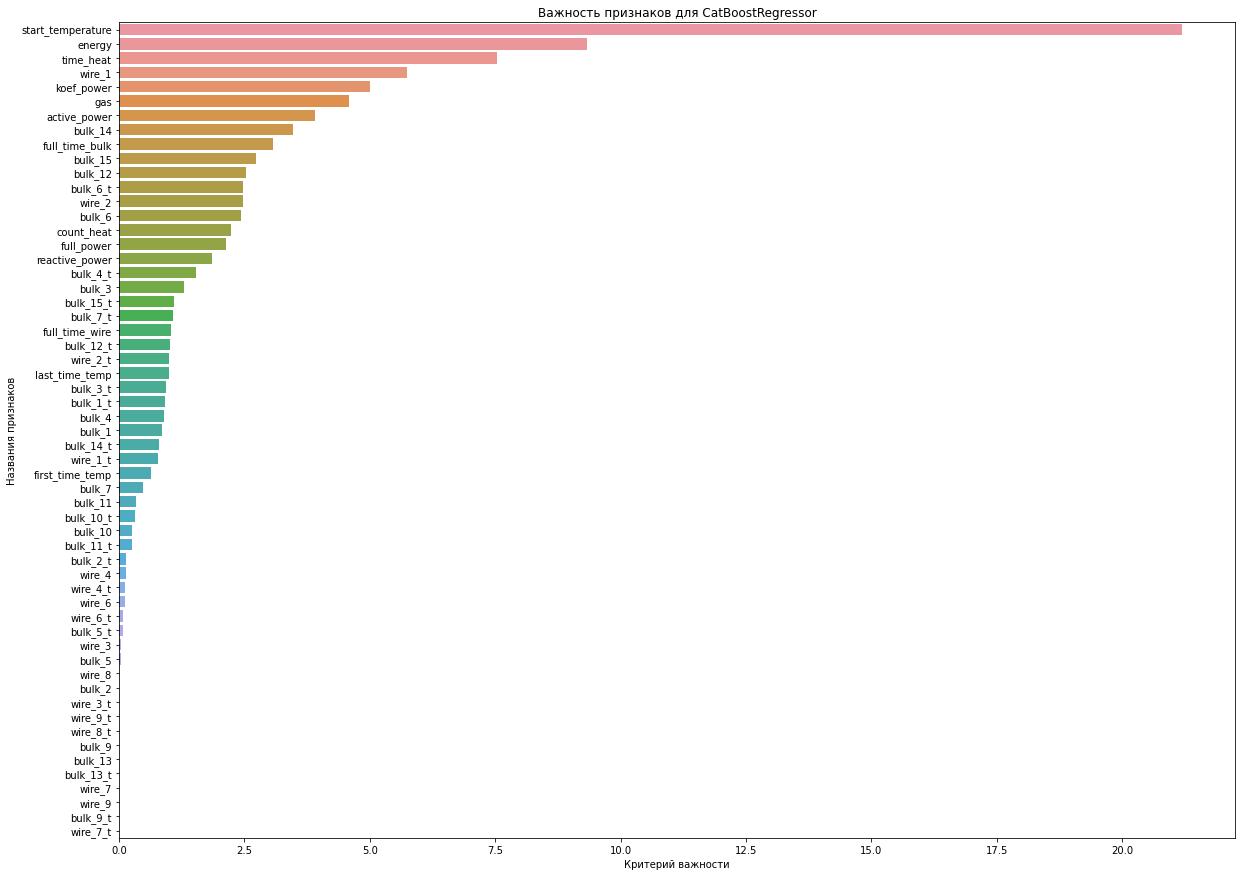

In [187]:
plot_data = {
    'features': features_test.columns,
    'feature_importance': model_cb.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importance', ascending=False, inplace=True)
plt.figure(figsize=(20, 15))
sns.barplot(x=plot_data['feature_importance'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor')
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()


Из полученных данных видим, что наиболее важным признаком для модели CatBoostRegressor является начальная температура. Далее следует время нагрева, energy, wire_1, koef_power и gas.

### Построим график зависимости выходной температуры от начальной температуры

<Figure size 1440x1080 with 0 Axes>

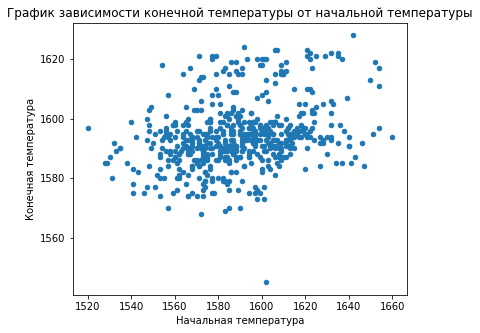

In [188]:
data_temp = {
    'start_temperature': features_test['start_temperature'],
    'finish_temperature': target_test,
}
data_temp = pd.DataFrame(data_temp)
plt.figure(figsize=(20, 15))
data_temp.plot(x='start_temperature', y='finish_temperature', kind='scatter', figsize= (6,5))
plt.title('График зависимости конечной температуры от начальной температуры')
plt.xlabel('Начальная температура')
plt.ylabel('Конечная температура')
plt.show()

Какой-то четко выраженной линейной зависимости здесь не наблюдается, но небольшой тренд, что при увелечении начальной температуры увеличивается конечная температура есть. Также можно видеть, что есть скученность значений в центре графика (при значении начальной температуры в пределах 1560 -1610) и достаточно большой разброс значений вокруг. 

**Вывод:** На данном этапе было сделано следующее:

- протестирована модель CatBoostRegressor, показавшая лучший результат на обучающей выборке, MAE на тестовой выборке показало результат улдовлетворяющий поставленной задаче МАЕ < 6.8;

- провели сравнение шаней моедели и константной модели DummyRegressor. МАЕ DummyRegressor составило 8.083, что хуже, чем данный показатель нашей модели.

- определили признаки, которые были наиболее значимы для модели CatBoostRegressor. Наиболее важный признак - начальная температура. Далее следует время нагрева, energy, wire_1, koef_power и gas.

- построили график зависимости конечной температуры от начальной температуры.

## Общий вывод

Переда нами стояла следующая задача - построить модель, которая будет предсказывать температуру сплава. Это необходимо, чтобы оптимизировать производственные расходы металлургического комбинат «Стальная птица», который решил уменьшить потребление электроэнергии на этапе обработки стали.

Для решения поставленной задачи нами было сделано следующее:

1. Загрузили следующие таблицы:

• data_arc — данные об электродах;

• data_bulk — данные об объёме сыпучих материалов;

• data_bulk_time — данные о времени подачи сыпучих материалов;

• data_gas — данные о продувке сплава газом;

• data_temp — данные об измерениях температуры;

• data_wire — данные об объёме проволочных материалов;

• data_wire_time — данные о времени подачи проволочных материалов.

Таблицы и их содержимое в целом соответсвуют описанию, за исключением таблиц data_wire и data_wire_time, где количество столбцов отличается от описания. Фактически присутсвуют столбцы - key, Wire 1, Wire 2, Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9. Также в ряде таблиц изменили название колонок, которые начинались с большой буквы, и столбы с форматом времени time перевели в секунды.

2. Проведена предварительная обработка данных и исследовательский анализ всех таблиц, сгенерированы ряд новых признаков (например время нагрева, полная мощность, коэффицент можности и др)

Из таблицы с замерами температуры был выделен целевой признак - finish_temperature

Данные объеденены в единый датафрейм по ключу key, с учетом того, что каждая партия стали нагревалась электродами, туда добавляли сыпучие материалы и проволку, а также продували инертными газами, поэтому объединение таблиц делали по принципу - inner.

В итоге был полученный общий датасет, размер которого сотавил 2150, 58.

3. Раздедили итоговый датасет на признаки и целевой признак - конечная температура (finish_temperature), которую мы патаемся предсказать в данном проекте. А также с помощью train_test_split() раздедили выборки на обучающую и тестовую выборку в соотношении 75 - 25.

4. Рассмотрли, обучули и подобрали гиперпараметры для 5 моделей: Ridger (линейная модель), RandomForestRegressor (случайный лес),  LightGBM (градиентный бустинг), CatBoostRegressor (градиентный бустинг), Model_improve (трехслойная полносвязная нейронная сеть). CatBoostRegressor рассматривали с дефолтными значениями и с подбором гиперпараметров. Модель с дефолтными значениями показала результат лучше, поэтому в итоговый рейтинг включили ее.
Из рассмотренных моделей лучше всего себя показала модель градиантного бустинга CatBoostRegressor, на дефолтных параметрах. Полученный значение метрики МАЕ соответсвует условию поставленной задачи, она менее 6.8.

5. На заключительном этапе:

- протестировали модель CatBoostRegressor, показавшую лучший результат на обучающей выборке, MAE на тестовой выборке показало результат улдовлетворяющий поставленной задаче МАЕ < 6.8;

- провели сравнение наней моедели и константной модели DummyRegressor. МАЕ DummyRegressor составило 8.083, что хуже, чем данный показатель нашей модели.

- определили признаки, которые были наиболее значимы для модели CatBoostRegressor. Наиболее важный признак - начальная температура. Далее следует время нагрева, energy, wire_1, koef_power и gas.

- построили график зависимости конечной температуры от начальной температуры.

Таким образом мы выполнили поставленную перед нами задачу и разработали модель, которая предсказывает конечную температуру сплава с метрикой качества МАЕ лучше, чем 6.8.